## Upload dataframe with predictions

In [38]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import os, re, ast
import json
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import train_test_split
from scipy.stats import trim_mean, gmean
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, MultiLabelBinarizer, StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, log_loss

In [16]:
df = pd.read_csv("data/predictions/predictions_df.csv")
df['pred_label'] = (df['probability_yes'] >= 0.5).astype(int)

accuracy = (
    df.groupby('setup', observed=True)
      .apply(lambda x: (x['pred_label'] == x['true_label']).mean())
      .rename('accuracy')
      .reset_index()
)

summary = df.groupby('setup', observed=True)['brier_score'].agg(['mean', 'count', 'std']).reset_index()
summary['ci95'] = 1.96 * summary['std'] / np.sqrt(summary['count'])

summary = summary.merge(accuracy, on='setup')
summary.sort_values("mean", ascending=True, inplace=True)

/var/folders/bd/nzks80913tb98ykz7ys3dfv00000gn/T/ipykernel_47004/1882597812.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x['pred_label'] == x['true_label']).mean())


In [ ]:
# summary[["setup", "mean", "accuracy"]].to_csv("data/predictions/summary.csv", index=False)

In [35]:
    # {'model':'deepseek_r1','prompt_type':'basic_prompt','n_articles':10,'k':3},
    # {'model':'deepseek_r1','prompt_type':'basic_prompt','n_articles':10,'k':2},
    # # {'model':'deepseek_r1','prompt_type':'basic_prompt','n_articles':10,'k':1},

    # # {'model':'deepseek_v3','prompt_type':'champs_know','n_articles':15,'k':4},
    # {'model':'deepseek_v3','prompt_type':'champs_know','n_articles':15,'k':3},
    # {'model':'deepseek_v3','prompt_type':'champs_know','n_articles':15,'k':2},
    # # {'model':'deepseek_v3','prompt_type':'champs_know','n_articles':15,'k':1},

    # # {'model':'deepseek_r1','prompt_type':'two_stages','n_articles':10,'k':3},

    # {'model':'mistral_3','prompt_type':'basic_prompt','n_articles':10,'k':3},
    # {'model':'gemini_flash','prompt_type':'basic_prompt','n_articles':10,'k':3},

df_for_calibration = df[df["setup"].isin([
    "deepseek_r1 | basic_prompt | 10 articles | 3",
    "deepseek_r1 | basic_prompt | 10 articles | 2",
    "deepseek_v3 | champs_know | 15 articles | 3",
    "deepseek_v3 | champs_know | 15 articles | 2",
    "gemini_flash | basic_prompt | 10 articles | 3",
    "mistral_3 | basic_prompt | 10 articles | 3"
])]

In [36]:
df_wide = (
    df_for_calibration.pivot_table(index=['event_id', 'true_label', 'end_date'],
                   columns='setup',
                   values='probability_yes')
      .reset_index()
)

df_wide

setup  event_id  true_label        end_date  \
0         10023           0  20240630040000   
1         10025           1  20240321230000   
2         10037           0  20240905040000   
3         10065           0  20240331120000   
4         10084           0  20240430120000   
..          ...         ...             ...   
995      903724           0  20240331000000   
996      903746           0  20241230120000   
997      903754           1  20240430120000   
998      903782           1  20240312000000   
999      903788           1  20240312000000   

setup  deepseek_r1 | basic_prompt | 10 articles | 2  \
0                                              0.10   
1                                              0.40   
2                                              0.30   
3                                              0.20   
4                                              0.30   
..                                              ...   
995                                            0.40   
996                                            0.08   
997                                            0.35   
998                                            0.95   
999                                            0.95   

setup  deepseek_r1 | basic_prompt | 10 articles | 3  \
0                                              0.10   
1                                              1.00   
2                                              0.30   
3                                              0.20   
4                                              0.25   
..                                              ...   
995                                            0.25   
996                                            0.10   
997                                            0.35   
998                                            0.95   
999                                            0.95   

setup  deepseek_v3 | champs_know | 15 articles | 2  \
0                                             0.10   
1                                             0.65   
2                                             0.25   
3                                             0.20   
4                                             0.20   
..                                             ...   
995                                           0.40   
996                                           0.10   
997                                           0.40   
998                                           0.95   
999                                           0.95   

setup  deepseek_v3 | champs_know | 15 articles | 3  \
0                                             0.15   
1                                             0.65   
2                                             0.30   
3                                             0.30   
4                                             0.20   
..                                             ...   
995                                           0.40   
996                                           0.15   
997                                           0.40   
998                                           0.95   
999                                           0.95   

setup  gemini_flash | basic_prompt | 10 articles | 3  \
0                                               0.05   
1                                               0.75   
2                                               0.35   
3                                               0.10   
4                                               0.25   
..                                               ...   
995                                             0.05   
996                                             0.05   
997                                             0.40   
998                                             0.99   
999                                             0.99   

setup  mistral_3 | basic_prompt | 10 articles | 3  
0                                            0.10  
1                                     

In [37]:
# wide table: по одному ряду на event
model_cols = df_wide.columns.difference(['event_id', 'true_label', 'end_date'])
df_wide['median_prob'] = df_wide[model_cols].median(axis=1)
df_wide['mean_prob']   = df_wide[model_cols].mean(axis=1)

df_wide

setup  event_id  true_label        end_date  \
0         10023           0  20240630040000   
1         10025           1  20240321230000   
2         10037           0  20240905040000   
3         10065           0  20240331120000   
4         10084           0  20240430120000   
..          ...         ...             ...   
995      903724           0  20240331000000   
996      903746           0  20241230120000   
997      903754           1  20240430120000   
998      903782           1  20240312000000   
999      903788           1  20240312000000   

setup  deepseek_r1 | basic_prompt | 10 articles | 2  \
0                                              0.10   
1                                              0.40   
2                                              0.30   
3                                              0.20   
4                                              0.30   
..                                              ...   
995                                            0.40   
996                                            0.08   
997                                            0.35   
998                                            0.95   
999                                            0.95   

setup  deepseek_r1 | basic_prompt | 10 articles | 3  \
0                                              0.10   
1                                              1.00   
2                                              0.30   
3                                              0.20   
4                                              0.25   
..                                              ...   
995                                            0.25   
996                                            0.10   
997                                            0.35   
998                                            0.95   
999                                            0.95   

setup  deepseek_v3 | champs_know | 15 articles | 2  \
0                                             0.10   
1                                             0.65   
2                                             0.25   
3                                             0.20   
4                                             0.20   
..                                             ...   
995                                           0.40   
996                                           0.10   
997                                           0.40   
998                                           0.95   
999                                           0.95   

setup  deepseek_v3 | champs_know | 15 articles | 3  \
0                                             0.15   
1                                             0.65   
2                                             0.30   
3                                             0.30   
4                                             0.20   
..                                             ...   
995                                           0.40   
996                                           0.15   
997                                           0.40   
998                                           0.95   
999                                           0.95   

setup  gemini_flash | basic_prompt | 10 articles | 3  \
0                                               0.05   
1                                               0.75   
2                                               0.35   
3                                               0.10   
4                                               0.25   
..                                               ...   
995                                             0.05   
996                                             0.05   
997                                             0.40   
998                                             0.99   
999                                             0.99   

setup  mistral_3 | basic_prompt | 10 articles | 3  median_prob  mean_prob  
0                                            0.10        0.100   0

In [53]:
# train / test split по дате
df_wide = df_wide.sort_values('end_date')
df_wide = df_wide.dropna()

In [104]:
good_seeds = []

for i in range(200):
    train, test = train_test_split(df_wide, test_size=0.6, random_state=i)
    # train, test = df_wide[:300].copy(), df_wide[300:].copy()

    # логистическая калибровка медианы
    cal = LogisticRegression(C=100)
    cal.fit(train[['mean_prob']], train['true_label'])

    test['calib_prob'] = cal.predict_proba(test[['mean_prob']])[:, 1]

    if (abs(brier_score_loss(test['true_label'], test['calib_prob']) - 0.178) < 0.001) and abs(accuracy_score(test['true_label'], (test['calib_prob'] >= 0.5).astype(int)) - 0.721) < 0.001:
        print(i)
        good_seeds.append(i)
        print('Brier:', brier_score_loss(test['true_label'], test['calib_prob']))
        print('Accuracy', accuracy_score(test['true_label'], (test['calib_prob'] >= 0.5).astype(int)))
        print('LogLoss:', log_loss(test['true_label'], test['calib_prob']))

96
Brier: 0.1783603339074964
Accuracy 0.7202680067001676
LogLoss: 0.5244153229435836
102
Brier: 0.1784254873052441
Accuracy 0.7219430485762144
LogLoss: 0.5222926393434232
158
Brier: 0.1777547855786371
Accuracy 0.7219430485762144
LogLoss: 0.5225964919138724


In [139]:
random_state = good_seeds[0]
train, test = train_test_split(df_wide, test_size=0.6, random_state=random_state)
# train, test = df_wide[:300].copy(), df_wide[300:].copy()

# логистическая калибровка медианы
cal = LogisticRegression(C=100)
cal.fit(train[['mean_prob']], train['true_label'])

test['calib_prob'] = cal.predict_proba(test[['mean_prob']])[:, 1]

print('Brier:', brier_score_loss(test['true_label'], test['calib_prob']))
print('Accuracy', accuracy_score(test['true_label'], (test['calib_prob'] >= 0.5).astype(int)))

Brier: 0.1783603339074964
Accuracy 0.7202680067001676


In [140]:
test

setup  event_id  true_label        end_date  \
337       13933           0  20241217120000   
455       15058           0  20250119120000   
576       16053           0  20250101020000   
658       16933           1  20250121120000   
695       17485           0  20250209120000   
..          ...         ...             ...   
880       19098           0  20250222220000   
188       12216           0  20240829120000   
791       18318           0  20250214013000   
493       15474           1  20241220120000   
254       13048           0  20240922120000   

setup  deepseek_r1 | basic_prompt | 10 articles | 2  \
337                                            0.35   
455                                            0.20   
576                                            0.45   
658                                            0.65   
695                                            0.60   
..                                              ...   
880                                            0.65   
188                                            0.95   
791                                            0.55   
493                                            0.80   
254                                            0.55   

setup  deepseek_r1 | basic_prompt | 10 articles | 3  \
337                                            0.70   
455                                            0.20   
576                                            0.40   
658                                            0.65   
695                                            0.60   
..                                              ...   
880                                            0.55   
188                                            0.05   
791                                            0.50   
493                                            0.85   
254                                            0.45   

setup  deepseek_v3 | champs_know | 15 articles | 2  \
337                                           0.45   
455                                           0.20   
576                                           0.35   
658                                           0.65   
695                                           0.60   
..                                             ...   
880                                           0.75   
188                                           0.90   
791                                           0.50   
493                                           0.85   
254                                           0.55   

setup  deepseek_v3 | champs_know | 15 articles | 3  \
337                                           0.35   
455                                           0.15   
576                                           0.40   
658                                           0.70   
695                                           0.65   
..                                             ...   
880                                           0.70   
188                                           0.95   
791                                           0.50   
493                                           0.85   
254                                           0.55   

setup  gemini_flash | basic_prompt | 10 articles | 3  \
337                                             0.05   
455                                             0.05   
576                                             0.40   
658                                             0.60   
695                                             0.55   
..                                               ...   
880                                             0.70   
188                                             0.99   
791                                             0.50   
493                                             0.95   
254                                             0.40   

setup  mistral_3 | basic_prompt | 10 articles | 3  median_prob  mean_prob  \
337                                          0.60        0.400   

Сравнение DeepSeek R1 k=3 VS Aggregation

In [142]:
from statsmodels.stats.contingency_tables import mcnemar

acc_A = ((test['deepseek_v3 | champs_know | 15 articles | 3'] >= 0.5).astype(int) == test['true_label'])
acc_B = ((test['calib_prob'] >= 0.5).astype(int) == test['true_label'])
n01 = ( acc_A & ~acc_B).sum()
n10 = (~acc_A &  acc_B).sum()

res = mcnemar([[0, n01], [n10, 0]], exact=(n01+n10)<25)
print(f'Δ accuracy = {acc_A.mean()-acc_B.mean():.4f}')
print(f"McNemar χ² = {res.statistic:.4f}, p = {res.pvalue:.6g}")

Δ accuracy = -0.0452
McNemar χ² = 5.8783, p = 0.015329


In [146]:
test

setup  event_id  true_label        end_date  \
337       13933           0  20241217120000   
455       15058           0  20250119120000   
576       16053           0  20250101020000   
658       16933           1  20250121120000   
695       17485           0  20250209120000   
..          ...         ...             ...   
880       19098           0  20250222220000   
188       12216           0  20240829120000   
791       18318           0  20250214013000   
493       15474           1  20241220120000   
254       13048           0  20240922120000   

setup  deepseek_r1 | basic_prompt | 10 articles | 2  \
337                                            0.35   
455                                            0.20   
576                                            0.45   
658                                            0.65   
695                                            0.60   
..                                              ...   
880                                            0.65   
188                                            0.95   
791                                            0.55   
493                                            0.80   
254                                            0.55   

setup  deepseek_r1 | basic_prompt | 10 articles | 3  \
337                                            0.70   
455                                            0.20   
576                                            0.40   
658                                            0.65   
695                                            0.60   
..                                              ...   
880                                            0.55   
188                                            0.05   
791                                            0.50   
493                                            0.85   
254                                            0.45   

setup  deepseek_v3 | champs_know | 15 articles | 2  \
337                                           0.45   
455                                           0.20   
576                                           0.35   
658                                           0.65   
695                                           0.60   
..                                             ...   
880                                           0.75   
188                                           0.90   
791                                           0.50   
493                                           0.85   
254                                           0.55   

setup  deepseek_v3 | champs_know | 15 articles | 3  \
337                                           0.35   
455                                           0.15   
576                                           0.40   
658                                           0.70   
695                                           0.65   
..                                             ...   
880                                           0.70   
188                                           0.95   
791                                           0.50   
493                                           0.85   
254                                           0.55   

setup  gemini_flash | basic_prompt | 10 articles | 3  \
337                                             0.05   
455                                             0.05   
576                                             0.40   
658                                             0.60   
695                                             0.55   
..                                               ...   
880                                             0.70   
188                                             0.99   
791                                             0.50   
493                                             0.95   
254                                             0.40   

setup  mistral_3 | basic_prompt | 10 articles | 3  median_prob  mean_prob  \
337                                          0.60        0.400   

In [188]:
test

setup  event_id  true_label        end_date  \
337       13933           0  20241217120000   
455       15058           0  20250119120000   
576       16053           0  20250101020000   
658       16933           1  20250121120000   
695       17485           0  20250209120000   
..          ...         ...             ...   
880       19098           0  20250222220000   
188       12216           0  20240829120000   
791       18318           0  20250214013000   
493       15474           1  20241220120000   
254       13048           0  20240922120000   

setup  deepseek_r1 | basic_prompt | 10 articles | 2  \
337                                            0.35   
455                                            0.20   
576                                            0.45   
658                                            0.65   
695                                            0.60   
..                                              ...   
880                                            0.65   
188                                            0.95   
791                                            0.55   
493                                            0.80   
254                                            0.55   

setup  deepseek_r1 | basic_prompt | 10 articles | 3  \
337                                            0.70   
455                                            0.20   
576                                            0.40   
658                                            0.65   
695                                            0.60   
..                                              ...   
880                                            0.55   
188                                            0.05   
791                                            0.50   
493                                            0.85   
254                                            0.45   

setup  deepseek_v3 | champs_know | 15 articles | 2  \
337                                           0.45   
455                                           0.20   
576                                           0.35   
658                                           0.65   
695                                           0.60   
..                                             ...   
880                                           0.75   
188                                           0.90   
791                                           0.50   
493                                           0.85   
254                                           0.55   

setup  deepseek_v3 | champs_know | 15 articles | 3  \
337                                           0.35   
455                                           0.15   
576                                           0.40   
658                                           0.70   
695                                           0.65   
..                                             ...   
880                                           0.70   
188                                           0.95   
791                                           0.50   
493                                           0.85   
254                                           0.55   

setup  gemini_flash | basic_prompt | 10 articles | 3  \
337                                             0.05   
455                                             0.05   
576                                             0.40   
658                                             0.60   
695                                             0.55   
..                                               ...   
880                                             0.70   
188                                             0.99   
791                                             0.50   
493                                             0.95   
254                                             0.40   

setup  mistral_3 | basic_prompt | 10 articles | 3  median_prob  mean_prob  \
337                                          0.60        0.400   

In [190]:
test["brier_score_r1"] = (test["deepseek_r1 | basic_prompt | 10 articles | 3"] - test["true_label"])**2
test["brier_score_v3"] = (test["deepseek_v3 | champs_know | 15 articles | 3"] - test["true_label"])**2
test["brier_score_gemini"] = (test["gemini_flash | basic_prompt | 10 articles | 3"] - test["true_label"])**2
test["brier_score_mistral"] = (test["mistral_3 | basic_prompt | 10 articles | 3"] - test["true_label"])**2
test["brier_score_calib_prob"] = (test["calib_prob"] - test["true_label"])**2
diff = test['brier_score_calib_prob'] - test['brier_score_mistral']          # Δ >0 → A хуже
rng  = np.random.default_rng(42)
B    = 10_000
boot = rng.choice(diff.to_numpy(), (B, len(diff)), replace=True).mean(axis=1)
ci_l_95, ci_h_95 = np.percentile(boot, [2.5, 97.5])
ci_l_99, ci_h_99 = np.percentile(boot, [0.05, 99.5])
print(f'mean diff in Brier = {diff.mean():.6f}')
print(f'95% CI  = [{ci_l_95:.6f}, {ci_h_95:.6f}]')
print(f'99% CI  = [{ci_l_99:.6f}, {ci_h_99:.6f}]')

mean diff in Brier = -0.028120
95% CI  = [-0.039643, -0.016786]
99% CI  = [-0.047298, -0.013113]


In [107]:
r1_3 = df[df["setup"] == "deepseek_r1 | basic_prompt | 10 articles | 3"][["event_id", "probability_yes", "brier_score", "pred_label", "true_label"]]
r1_4 = df[df["setup"] == "deepseek_r1 | basic_prompt | 10 articles | 4"][["event_id", "probability_yes", "brier_score", "pred_label", "true_label"]]

In [110]:
import pandas as pd, numpy as np
from statsmodels.stats.contingency_tables import mcnemar

# r1_3, r1_4 – готовые датафреймы
data = r1_3.merge(r1_4, on='event_id', suffixes=('_A', '_B'))

# Accuracy + McNemar
acc_A = (data['pred_label_A'] == data['true_label_A'])
acc_B = (data['pred_label_B'] == data['true_label_B'])
n01 = ( acc_A & ~acc_B).sum()
n10 = (~acc_A &  acc_B).sum()
res = mcnemar([[0, n01], [n10, 0]], exact=(n01+n10)<25)
print(f'Δ accuracy = {acc_A.mean()-acc_B.mean():.4f}')
print(f"McNemar χ² = {res.statistic:.4f}, p = {res.pvalue:.6g}")

# Brier paired bootstrap
diff = data['brier_score_A'] - data['brier_score_B']          # Δ >0 → A хуже
rng  = np.random.default_rng(42)
B    = 10_000
boot = rng.choice(diff.to_numpy(), (B, len(diff)), replace=True).mean(axis=1)
ci_l, ci_h = np.percentile(boot, [2.5, 97.5])
print(f'Δ Brier = {diff.mean():.6f}')
print(f'95% CI  = [{ci_l:.6f}, {ci_h:.6f}]')

Δ accuracy = -0.0120
McNemar χ² = 0.6050, p = 0.436677
Δ Brier = 0.004564
95% CI  = [-0.005589, 0.014604]


So from here we right away see that the best untouched metric achieved on the entire dataset of 1000 questions (selected randomly from the 5700 of initial dataset) is **0.18** by brier score

## Main functions

In [5]:
def plot_bar_with_error(
    labels: list[str],
    means: list[float],
    sems: list[float],
    title: str,
    ylabel: str,
    figsize: tuple[int, int] = (6, 6),
    palette: list[str] | None = None,
    ylim: tuple[float, float] | None = None,
    rotation: float = 45,
):
    x = np.arange(len(labels))
    width = 0.75
    
    fig, ax = plt.subplots(figsize=figsize)
    
    if palette is None:
        cmap = plt.get_cmap("Blues", len(labels))
        palette = [cmap(i) for i in range(len(labels))]

    bars = ax.bar(
        x, means, width,
        yerr=sems,
        capsize=5,
        color=palette,
        edgecolor="gray",
        linewidth=0.8,
    )
    
    ax.set_title(title, fontsize=16, pad=15)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=rotation, ha="right", fontsize=12)
    
    if ylim is not None:
        ax.set_ylim(*ylim)
    else:
        y_min, y_max = min(means) - max(sems)*2, max(means) + max(sems)*2
        ax.set_ylim(y_min, y_max)
    
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.yaxis.grid(True, linestyle="--", alpha=0.6)
    ax.set_axisbelow(True)

    for bar, m in zip(bars, means):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + max(sems)*1.1,
            f"{m:.3f}",
            ha="center",
            va="bottom",
            fontsize=10
        )
    
    plt.tight_layout()
    plt.show()

# Metrics

The key metrics we will consider are Brier Score, Accuracy and AUC-ROC

Just defining functions below

In [163]:
def compute_metrics(y_true, y_pred):
    return {
        'brier_score': brier_score_loss(y_true, y_pred),
        'accuracy':    accuracy_score(y_true, y_pred >= 0.5),
        'auc':         roc_auc_score(y_true, y_pred)
    }



def plot_metrics_over_time(
    df,
    models,
    # metrics_list=['brier_score', 'accuracy', 'auc'],
    metrics_list=["brier_score"],
    n_seeds=10,
    test_size=0.2,
    shade_metrics=['brier_score'],
    figsize=(8, 5),
    palette=None
):
    ks = sorted(df['k'].unique())
    n_models = len(models)
    
    if palette is None:
        cmap = plt.get_cmap("tab10", n_models)
        colors = [cmap(i) for i in range(n_models)]
    else:
        colors = palette

    markers = ["o", "s", "D", "v"]

    for metric in metrics_list:
        fig, ax = plt.subplots(figsize=figsize)
        for idx, model in enumerate(models):
            mean_vals = []
            sem_vals = []
            for k in ks:
                sub = df[(df['model'] == model) & (df['k'] == k) & (df["prompt_type"].isin(["champs_know", "basic_prompt"]))]
                y = sub['true_label'].values
                p = sub['probability_yes'].values
                
                if metric in shade_metrics:
                    scores = []
                    indices = np.arange(len(y))
                    for seed in range(n_seeds):
                        _, idx_test = train_test_split(indices, test_size=test_size, random_state=seed)
                        scores.append(brier_score_loss(y[idx_test], p[idx_test]))
                    scores = np.array(scores)
                    mean_vals.append(scores.mean())
                    sem_vals.append(scores.std(ddof=1) / np.sqrt(n_seeds))
                else:
                    mean_vals.append(compute_metrics(y, p)[metric])
                    sem_vals.append(0)

            ax.plot(ks, mean_vals, marker=markers[idx], label=model, color=colors[idx], linewidth=2)
            if metric in shade_metrics:
                mean_vals = np.array(mean_vals)
                sem_vals = np.array(sem_vals)
                # ax.fill_between(ks, mean_vals - sem_vals, mean_vals + sem_vals,
                #                 color=colors[idx], alpha=0.2)

        ax.set_title(f"{metric.capitalize()} over prediction time", fontsize=16, weight='bold', pad=10)
        ax.set_xlabel("k (timestamp)", fontsize=14)
        ax.set_ylabel(metric.replace('_', ' ').capitalize(), fontsize=14)
        ax.set_xticks(ks)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.yaxis.grid(True, linestyle="--", alpha=0.6)
        ax.set_axisbelow(True)
        ax.legend(title="Model", loc="upper right")
        plt.tight_layout()
        plt.show()



def plot_before_after_calibration_bar(df, models, n_seeds=20, test_size=0.45):
    records = []
    for m in models:
        sub = df[(df['model'] == m) & (df['k'] == 3)]
        y = sub['true_label'].values
        preds = sub['probability_yes'].values
        
        raw_scores = {'brier_score': [], 'accuracy': []}
        cal_scores = {'brier_score': [], 'accuracy': []}
        
        for seed in range(n_seeds):
            y_train, y_test, p_train, p_test = train_test_split(
                y, preds, test_size=test_size, random_state=seed
            )
            # raw
            raw_m = compute_metrics(y_test, p_test)
            for k, v in raw_m.items():
                if k == "auc":
                    continue
                raw_scores[k].append(v)
            # calibration
            lr = LogisticRegression()
            lr.fit(p_train.reshape(-1,1), y_train)
            p_cal = lr.predict_proba(p_test.reshape(-1,1))[:,1]
            cal_m = compute_metrics(y_test, p_cal)
            for k, v in cal_m.items():
                if k == "auc":
                    continue
                cal_scores[k].append(v)
        avg_raw = {k: np.mean(v) for k, v in raw_scores.items()}
        avg_cal = {k: np.mean(v) for k, v in cal_scores.items()}
        
        records.append({'model': m, **{f'raw_{k}': v for k, v in avg_raw.items()}, **{f'cal_{k}': v for k, v in avg_cal.items()}})
    
    df_res = pd.DataFrame(records)
    df_res.set_index('model', inplace=True)

    for metric in ['brier_score', 'accuracy']:
        plt.figure(figsize=(6,4))
        x = np.arange(len(models))
        raw_vals = df_res[f'raw_{metric}'].values
        cal_vals = df_res[f'cal_{metric}'].values
        width = 0.35
        plt.bar(x - width/2, raw_vals, width, label='Raw')
        plt.bar(x + width/2, cal_vals, width, label='Calibrated')
        plt.xticks(x, models, rotation=45)
        plt.ylim(top = 0.8 if metric != 'brier_score' else 0.25, bottom = 0.6 if metric != "brier_score" else 0.1)
        plt.ylabel(metric)
        plt.title(f'Before vs After Calibration: {metric}', weight='bold')
        plt.legend()
        plt.grid(alpha=0.5, axis='y')
        plt.tight_layout()
        plt.show()

    return df_res



def plot_aggregation_metrics(
    df,
    setups,
    methods=['mean', 'median', 'trimmed_mean'],
    figsize=(6, 4),
    palette=None,
    rotation=45
):
    subsets = [
        df[(df['model']==s['model']) &
           (df['prompt_type']==s['prompt_type']) &
           (df['n_articles']==s['n_articles']) &
           (df['k']==s['k'])].sort_values('event_id')
        for s in setups
    ]
    common = set.intersection(*(set(sub['event_id']) for sub in subsets))
    arr = np.vstack([sub[sub['event_id'].isin(common)]['probability_yes'].values for sub in subsets])
    y_true = subsets[0][subsets[0]['event_id'].isin(common)]['true_label'].values

    funcs = {
        'mean':           lambda x: np.mean(x, axis=0),
        'median':         lambda x: np.median(x, axis=0),
        'trimmed_mean':   lambda x: np.mean(np.sort(x, axis=0)[1:-1], axis=0) 
                                  if x.shape[0] > 2 else np.mean(x, axis=0),
    }

    results = {}
    for m in methods:
        if m not in funcs:
            raise ValueError(f"Неизвестный метод: {m}")
        preds = funcs[m](arr)
        results[m] = compute_metrics(y_true, preds)

    tops    = {'brier_score': 0.25, 'accuracy': 0.9, 'auc': 0.95}
    bottoms = {'brier_score': 0.0,  'accuracy': 0.6, 'auc': 0.7}

    if palette is None:
        cmap = plt.get_cmap("Blues", len(methods))
        colors = [cmap(i) for i in range(len(methods))]
    else:
        colors = palette

    for i, metric in enumerate(['brier_score', 'accuracy', 'auc']):
        labels = methods
        means  = [results[m][metric] for m in methods]
        x      = np.arange(len(labels))
        width  = 0.75

        fig, ax = plt.subplots(figsize=figsize)
        bars = ax.bar(
            x, means, width,
            color=colors,
            edgecolor="gray",
            linewidth=0.8
        )

        for bar, val in zip(bars, means):
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                val + (tops[metric] - bottoms[metric]) * 0.02,
                f"{val:.3f}",
                ha="center",
                va="bottom",
                fontsize=10
            )

        ax.set_title(f"Aggregation methods: {metric}", fontsize=14, pad=10, weight='bold')
        ax.set_ylabel(metric.capitalize(), fontsize=12)
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=rotation, ha="right", fontsize=11)
        ax.set_ylim(bottoms[metric], tops[metric])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.yaxis.grid(True, linestyle='--', alpha=0.6)
        ax.set_axisbelow(True)

        plt.tight_layout()
        plt.show()
    
    return results



def plot_setup_comparison_bar(
    df,
    setups,
    metrics_list=['brier_score', 'accuracy', 'auc'],
    figsize=(6, 4),
    palette=None,
    rotation=45
):
    results = {}
    for i, (label, s) in enumerate(setups.items()):
        sub = df[(df['model']==(s['model'] or "deepseek_r1")) &
                 (df['prompt_type']==(s['prompt_type'] or "two_stages")) &
                 (df['n_articles']==(s['n_articles'] or 10)) &
                 (df['k']==(s['k'] or 3))]
        y_true = sub['true_label']
        y_pred = sub.get('probability_yes') if i != 0 else sub['base_rate']
        results[label] = compute_metrics(y_true, y_pred)

    labels = list(results.keys())
    n = len(labels)
    if palette is None:
        cmap = plt.get_cmap("Blues", n)
        colors = [cmap(i) for i in range(n)]
    else:
        colors = palette

    for metric in metrics_list:
        means = [results[l][metric] for l in labels]
        x = np.arange(n)
        width = 0.75

        fig, ax = plt.subplots(figsize=figsize)
        bars = ax.bar(
            x, means, width,
            color=colors,
            edgecolor="gray",
            linewidth=0.8
        )

        y_max = max(means)
        y_min = min(means)
        margin = (y_max - y_min) * 0.1
        for bar, val in zip(bars, means):
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                val + margin * 0.2,
                f"{val:.3f}",
                ha="center", va="bottom",
                fontsize=10
            )

        ax.set_title(f"Setup comparison: {metric}", fontsize=14, pad=10, weight='bold')
        ax.set_ylabel(metric.capitalize(), fontsize=12)
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=rotation, ha="right", fontsize=11)
        ax.set_ylim(y_min - margin, y_max + margin)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.yaxis.grid(True, linestyle='--', alpha=0.6)
        ax.set_axisbelow(True)

        plt.tight_layout()
        plt.show()

    return results



def plot_models_by_factor(df, models, factor, factor_values, metrics_list=['brier_score','accuracy','auc']):
    for metric in metrics_list:
        plt.figure(figsize=(8,5))
        x = np.arange(len(factor_values))
        width = 0.35
        for i, m in enumerate(models):
            vals = []
            for v in factor_values:
                sub = df[(df['model']==m)&(df[factor]==v)&(df['k']==4)]
                vals.append(compute_metrics(sub['true_label'], sub['probability_yes'])[metric])
            plt.bar(x + (i-0.5)*width, vals, width, label=m)
        plt.xticks(x, factor_values, rotation=45)
        plt.ylabel(metric)
        plt.title(f'{metric.capitalize()} by {factor}', weight='bold')
        plt.legend()
        plt.grid(axis='y')
        plt.tight_layout()
        plt.show()

## **Metrics evolution through time** (IMPORTANT)

Let's have a look at how metrics progress over time with the growth of prediction date $k\ \in (1, 2, 3, 4)$ :
$$\text{pred date}_k= \text{start date} + (\text{end date} - \text{start date} - 1) \cdot k/4$$

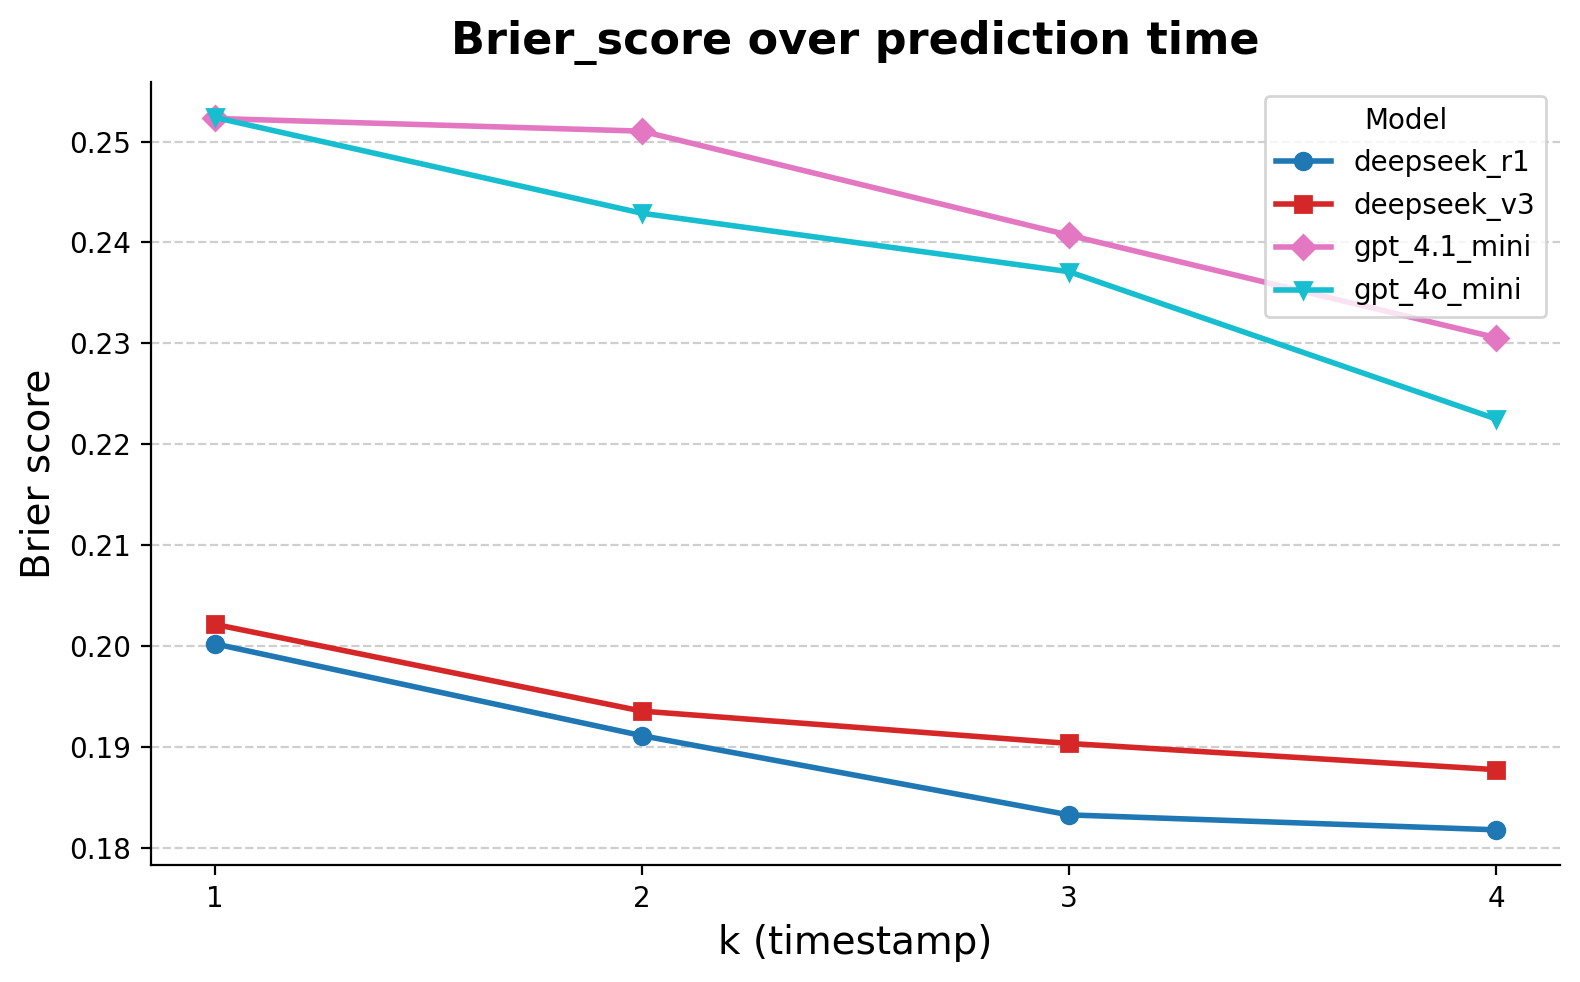

In [164]:
plot_metrics_over_time(df, ['deepseek_r1','deepseek_v3', "gpt_4.1_mini", "gpt_4o_mini"])

We can clearly see here that the metrics improve as the resolution date of the event approaches, meaning that the incoming data boosts model accuracy in prediction.

## Calibration effect on single models

Let's see how individual models are affected by the calibration. The metrics we are interested in are Brier Score and accuracy, since AUC-ROC is not affected by monotonous scaling.

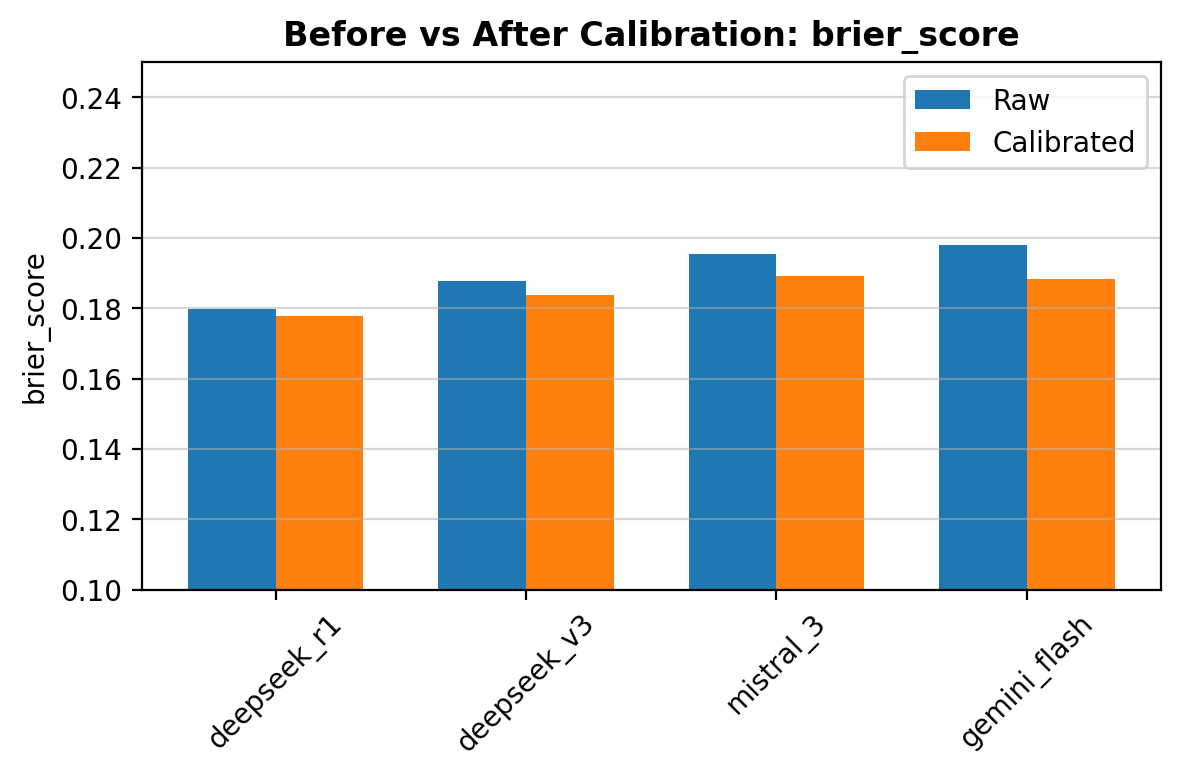

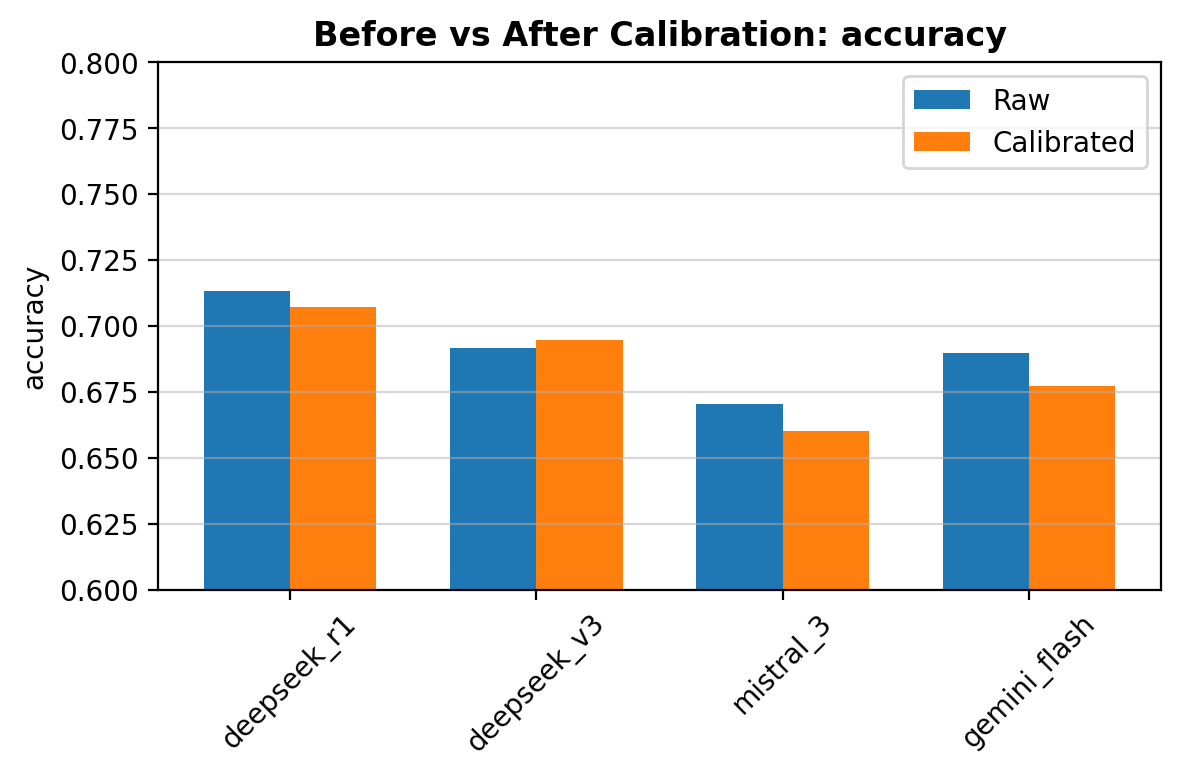

In [301]:
models_calibration_results = plot_before_after_calibration_bar(df, ['deepseek_r1','deepseek_v3','mistral_3','gemini_flash'], n_seeds=100)

In [271]:
models_calibration_results

raw_brier_score  raw_accuracy  cal_brier_score  cal_accuracy
model                                                                     
deepseek_r1          0.179723      0.713178         0.177793      0.707289
deepseek_v3          0.187751      0.691800         0.183787      0.694711
mistral_3            0.195553      0.670289         0.189167      0.660089
gemini_flash         0.198169      0.689911         0.188383      0.677200

These calibration by metric results suggest that calibration helps improve the brier scores, but does not consisently boost the accuracy of the models, actually decreasing the initial accuracy in some cases. The best achieved brier score on individual calibration is 0.178 on calibrated DeepSeek R1, demeaned by 100 random seeds.

## Exploring aggregation methods

### How does aggregation affect individual models?

Let's have a look at how DeepSeekR1 metrics are affected by aggregation across prediction dates (k=1,2,3,4).

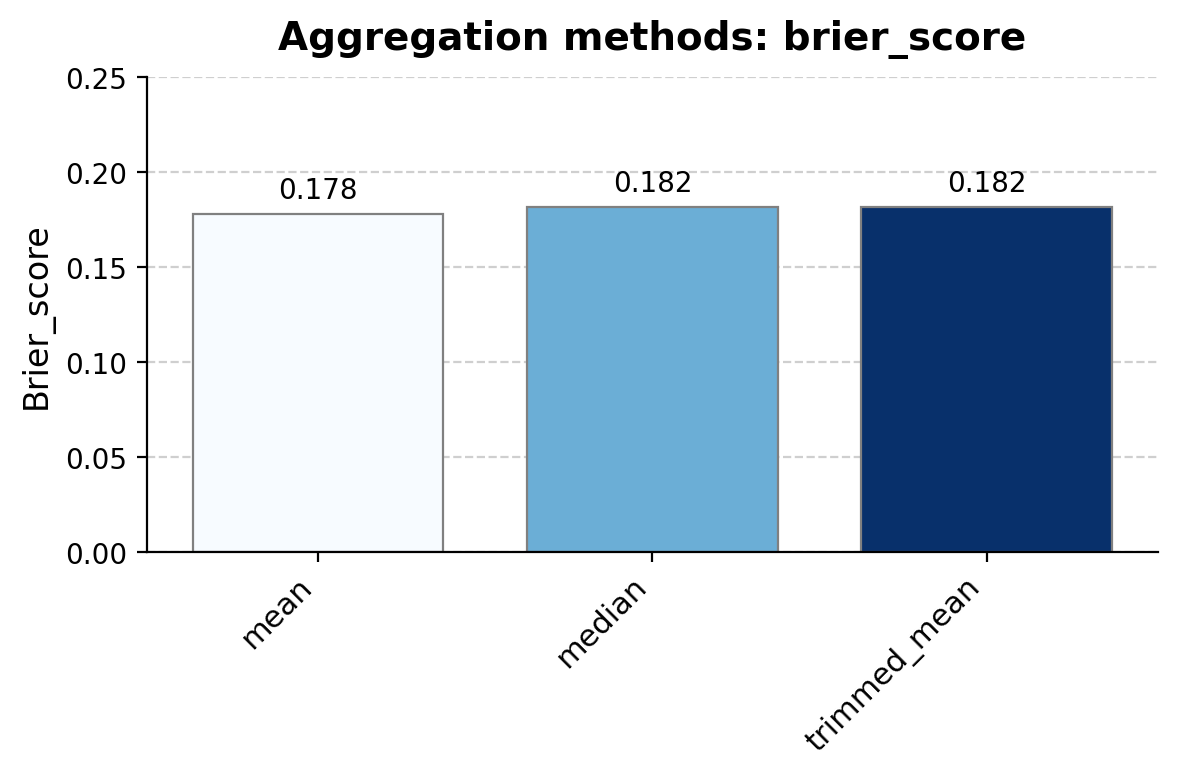

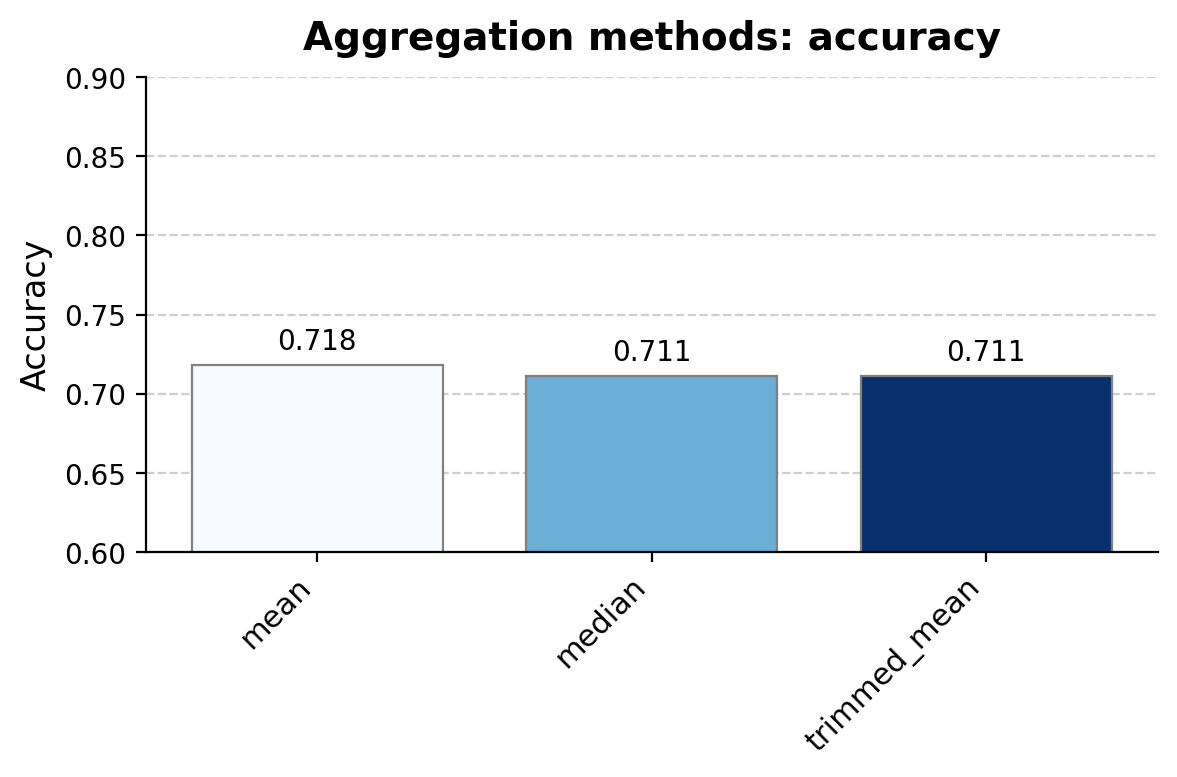

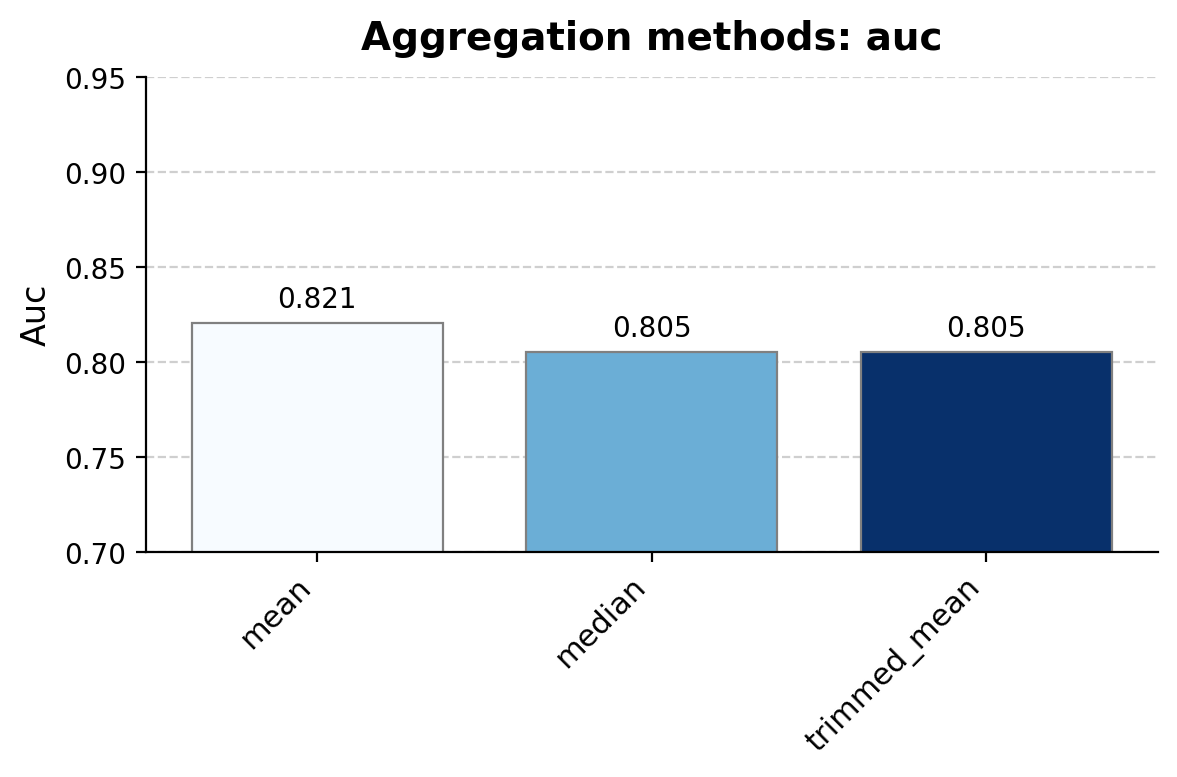

In [278]:
deepseek_r1_res = plot_aggregation_metrics(df, setups=[
    {'model':'deepseek_r1','prompt_type':'basic_prompt','n_articles':10,'k':4},
    {'model':'deepseek_r1','prompt_type':'basic_prompt','n_articles':10,'k':3},
    {'model':'deepseek_r1','prompt_type':'basic_prompt','n_articles':10,'k':2},
    {'model':'deepseek_r1','prompt_type':'basic_prompt','n_articles':10,'k':1},
])

In [279]:
deepseek_r1_res

{'mean': {'brier_score': 0.17813691073219662,
  'accuracy': 0.7181544633901705,
  'auc': 0.8206016896764887},
 'median': {'brier_score': 0.18174232698094284,
  'accuracy': 0.7111334002006018,
  'auc': 0.8054378734803214},
 'trimmed_mean': {'brier_score': 0.18174232698094284,
  'accuracy': 0.7111334002006018,
  'auc': 0.8054378734803214}}

Averaging across time yields 0.178 brier score, which is a little better than the single results at the last timestamp. The developing view can benefit from earlier predictions, which can sometimes rely more on historic prospective. However, the effect is not very large compared to taking the last prediction at k=4.

### How do predictions improve if we aggregate the best models' probabilities?

Let's see whether aggregating the strongest models with the weaker ones (but still good ones) yields better results. We will once again try three aggregation methods: mean, median, trimmed mean. The selected setups for aggregation include the best models predictions at different prediction dates.

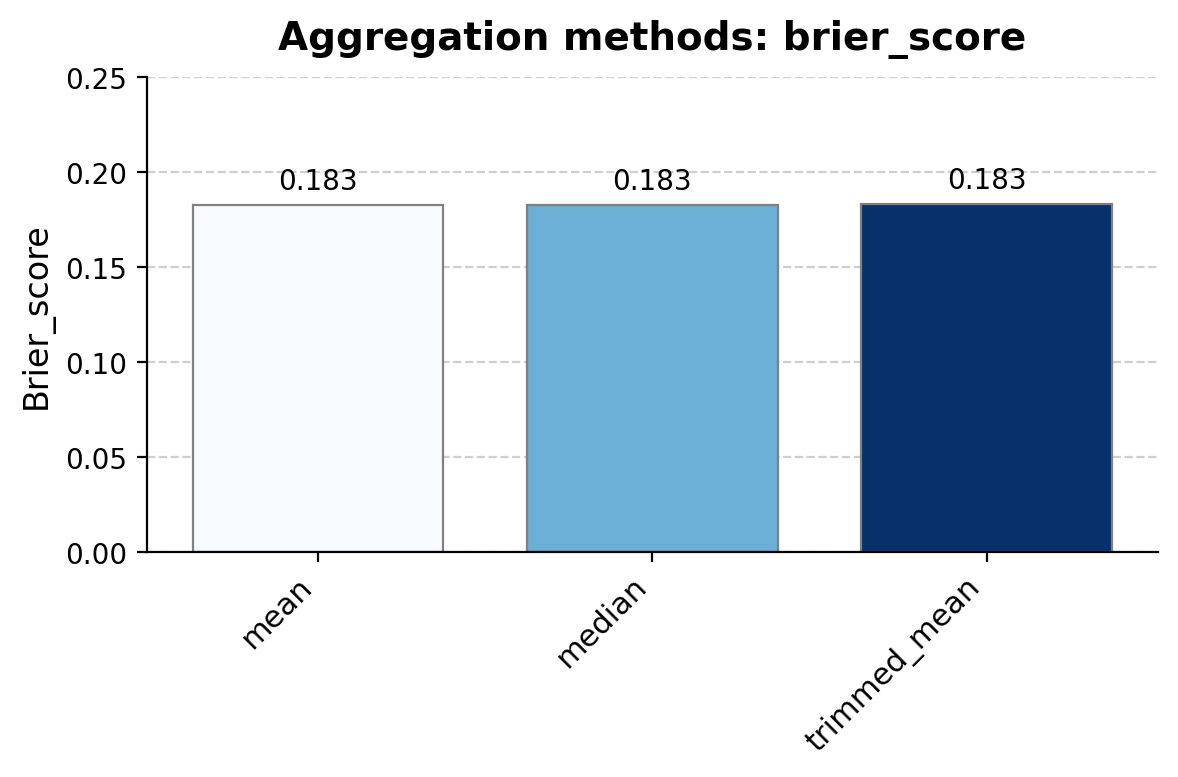

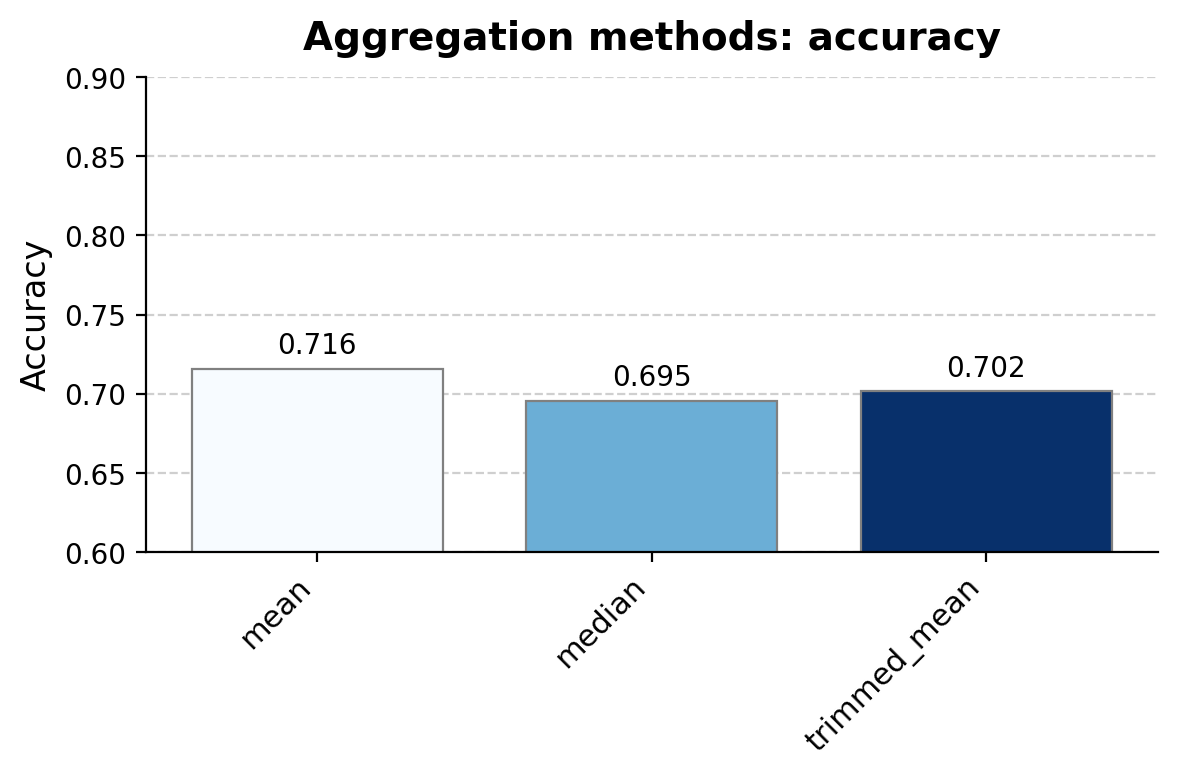

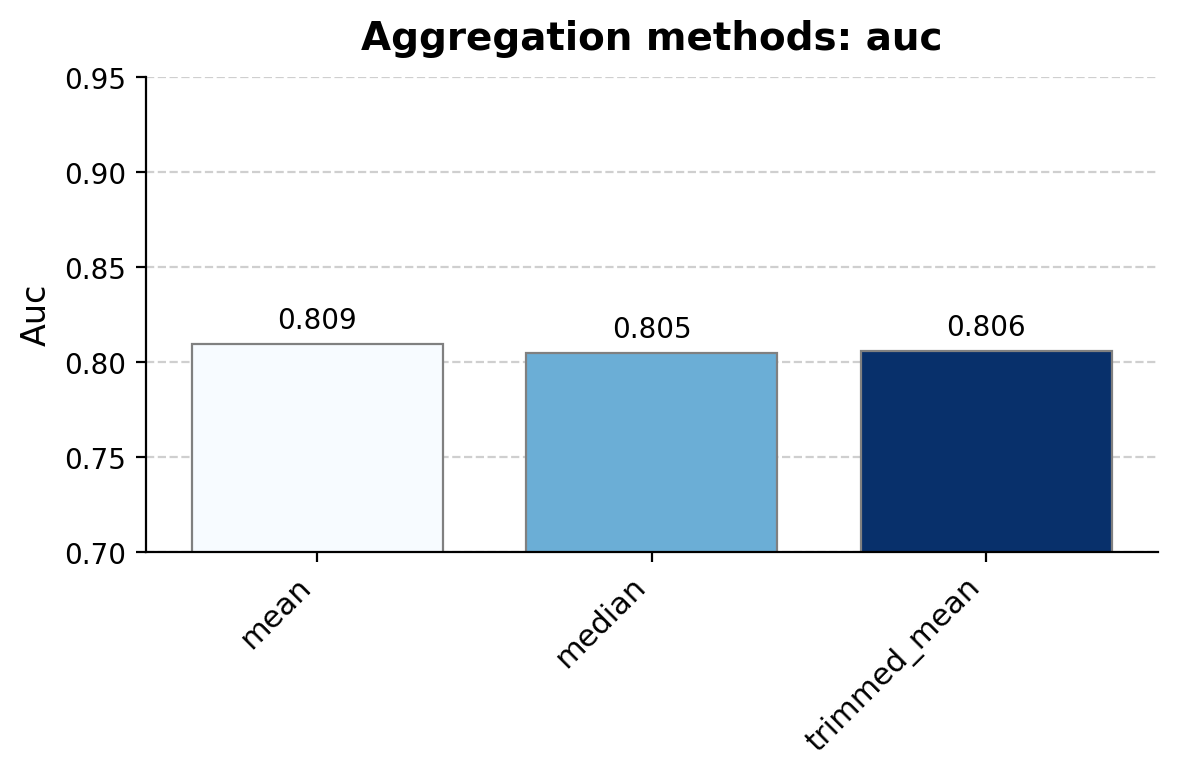

In [13]:
aggregations_res = plot_aggregation_metrics(df, setups=[
    # {'model':'deepseek_r1','prompt_type':'basic_prompt','n_articles':10,'k':4},
    {'model':'deepseek_r1','prompt_type':'basic_prompt','n_articles':10,'k':3},
    {'model':'deepseek_r1','prompt_type':'basic_prompt','n_articles':10,'k':2},
    # {'model':'deepseek_r1','prompt_type':'basic_prompt','n_articles':10,'k':1},

    # {'model':'deepseek_v3','prompt_type':'champs_know','n_articles':15,'k':4},
    {'model':'deepseek_v3','prompt_type':'champs_know','n_articles':15,'k':3},
    {'model':'deepseek_v3','prompt_type':'champs_know','n_articles':15,'k':2},
    # {'model':'deepseek_v3','prompt_type':'champs_know','n_articles':15,'k':1},

    {'model':'mistral_3','prompt_type':'basic_prompt','n_articles':10,'k':3},
    {'model':'gemini_flash','prompt_type':'basic_prompt','n_articles':10,'k':3}
    ])

In [260]:
aggregations_res

{'mean': {'brier_score': 0.1760104500504541,
  'accuracy': 0.7164480322906155,
  'auc': 0.8372963287077552},
 'median': {'brier_score': 0.1790229061553986,
  'accuracy': 0.7043390514631686,
  'auc': 0.8160040838438137},
 'trimmed_mean': {'brier_score': 0.1752973243567104,
  'accuracy': 0.7174571140262361,
  'auc': 0.8350522982039423}}

The best aggregation technique for the best setups is using the trimmed mean - demeaning the. The brier score it achieves is the lowest with 0.175 and an accuracy of 0.71. But can it be improved further by calibration?

### **Inside view VS Outside view (Base rates)** (IMPORTANT)

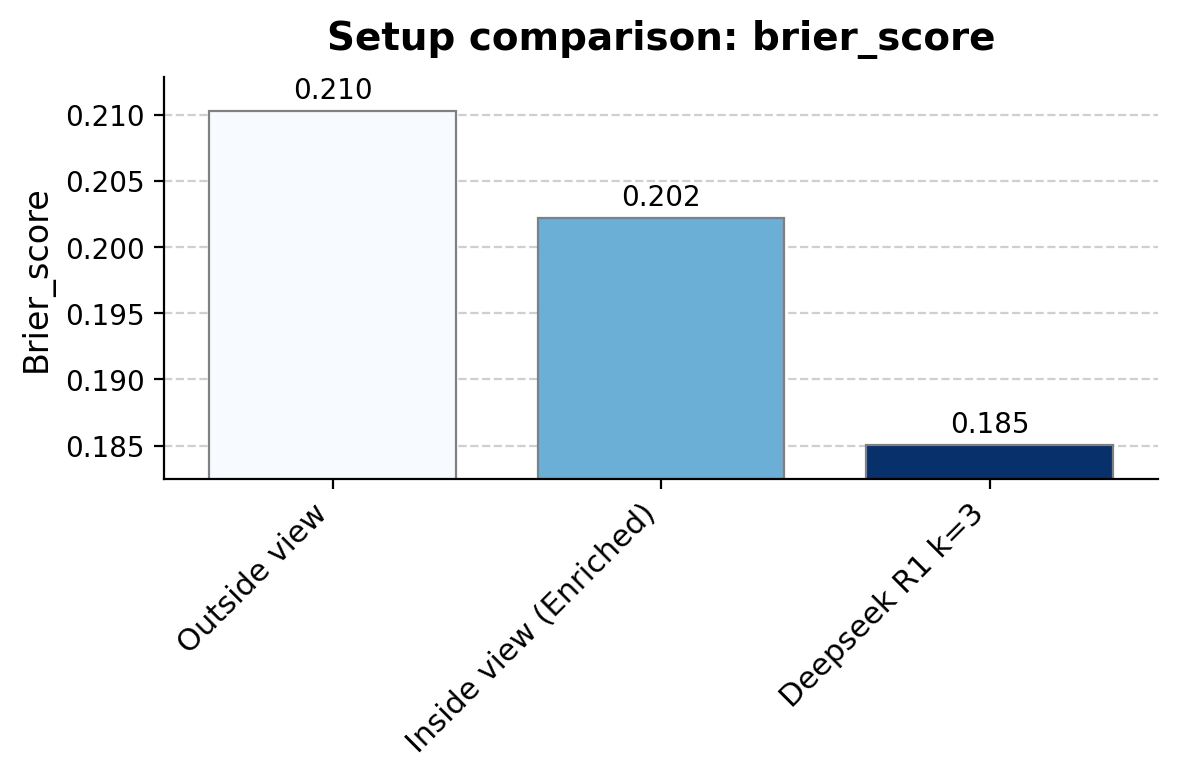

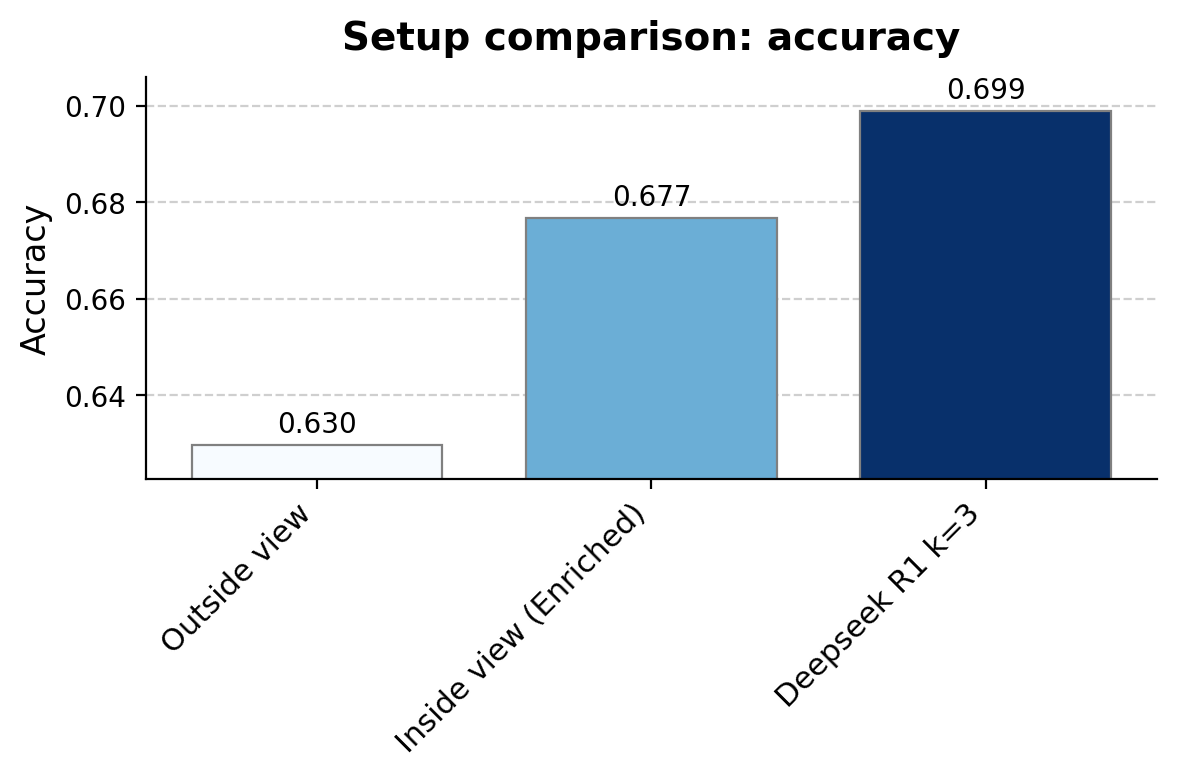

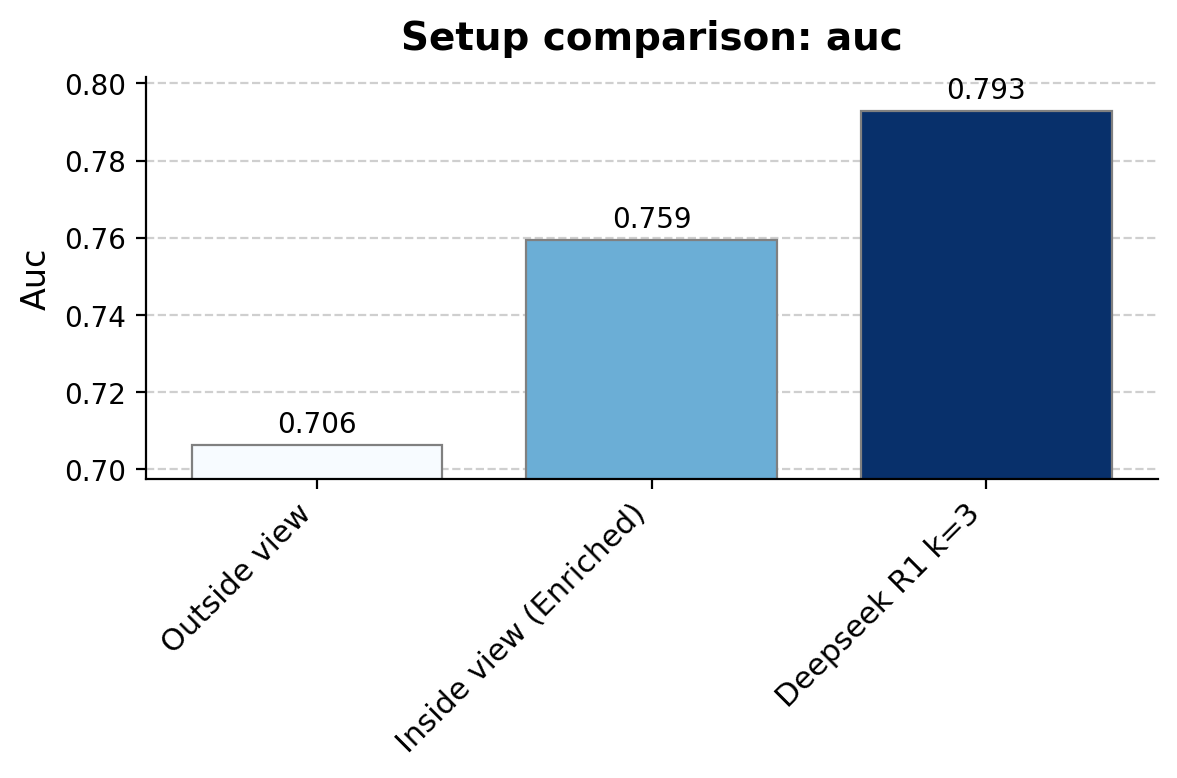

In [289]:
inside_outside_results = plot_setup_comparison_bar(df, {
    'Outside view': {'model':None,'prompt_type':None,'n_articles':None,'k':None,'use':'base_rate'},
    'Inside view (Enriched)': {'model':'deepseek_r1','prompt_type':'two_stages','n_articles':10,'k':3},
    'Deepseek R1 k=3': {'model':'deepseek_r1','prompt_type':'basic_prompt','n_articles':10,'k':3},
},)

In [290]:
inside_outside_results

{'Outside view': {'brier_score': 0.2102953953953954,
  'accuracy': 0.6296296296296297,
  'auc': 0.7062175761754662},
 'Inside view (Enriched)': {'brier_score': 0.20218398398398402,
  'accuracy': 0.6766766766766766,
  'auc': 0.7593495534541632},
 'Deepseek R1 k=3': {'brier_score': 0.18501170000000003,
  'accuracy': 0.699,
  'auc': 0.7929127180205761}}

So we see that no results are better than the classic pipeline on the strongest model. Opposite to expectations, the base rates so not improve predictions, since Polymarket offers mostly unique questions not seen before, with very few base classes.

## **Calibrating the aggregate predictions** (IMPORTANT)

In [22]:
def evaluate_aggregated_calibration(
    df: pd.DataFrame,
    setups: list[dict],
    methods: list[str] = ['mean', 'median', 'trimmed_mean'],
    n_seeds: int = 10,
    test_size: float = 0.5,
    calibration: str = 'logistic'
) -> pd.DataFrame:
    subsets = [
        df[(df['model']==s['model']) &
           (df['prompt_type']==s['prompt_type']) &
           (df['n_articles']==s['n_articles']) &
           (df['k']==s['k'])].sort_values('event_id')
        for s in setups
    ]
    common = set.intersection(*(set(sub['event_id']) for sub in subsets))
    arr = np.vstack([
        sub[sub['event_id'].isin(common)]['probability_yes'].values
        for sub in subsets
    ])
    y_true_all = subsets[0][subsets[0]['event_id'].isin(common)]['true_label'].values

    funcs = {
        'mean':           lambda x: np.mean(x, axis=0),
        'median':         lambda x: np.median(x, axis=0),
        'trimmed_mean':   lambda x: np.mean(np.sort(x, axis=0)[1:-1], axis=0) 
                                  if x.shape[0] > 2 else np.mean(x, axis=0),
    }

    records = []
    for m in methods:
        if m not in funcs:
            continue
        raw_metrics = {'brier_score': [], 'accuracy': [], 'auc': []}
        cal_metrics = {'brier_score': [], 'accuracy': [], 'auc': []}

        preds_all = funcs[m](arr)
        for seed in range(n_seeds):
            idx = np.arange(len(y_true_all))
            train_idx, test_idx = train_test_split(idx, test_size=test_size, random_state=seed)

            y_train, y_test = y_true_all[train_idx], y_true_all[test_idx]
            p_train, p_test = preds_all[train_idx], preds_all[test_idx]

            rm = compute_metrics(y_test, p_test)
            for k, v in rm.items():
                raw_metrics[k].append(v)

            if calibration == 'logistic':
                model = LogisticRegression()
                model.fit(p_train.reshape(-1,1), y_train)
                p_test_cal = model.predict_proba(p_test.reshape(-1,1))[:,1]
            else:
                ir = IsotonicRegression(out_of_bounds='clip')
                ir.fit(p_train, y_train)
                p_test_cal = ir.transform(p_test)

            cm = compute_metrics(y_test, p_test_cal)
            for k, v in cm.items():
                cal_metrics[k].append(v)

        # averaging by seeds just for robustness
        avg_raw = {f'raw_{k}': np.mean(v) for k, v in raw_metrics.items()}
        avg_cal = {f'cal_{k}': np.mean(v) for k, v in cal_metrics.items()}
        records.append({'method': m, **avg_raw, **avg_cal})

    df_res = pd.DataFrame(records)
    return df_res

In [79]:
evaluate_aggregated_calibration(df, setups = [
    {'model':'deepseek_r1','prompt_type':'basic_prompt','n_articles':10,'k':3},
    {'model':'deepseek_r1','prompt_type':'basic_prompt','n_articles':10,'k':2},
    # {'model':'deepseek_r1','prompt_type':'basic_prompt','n_articles':10,'k':1},
])

method  raw_brier_score  raw_accuracy   raw_auc  cal_brier_score  \
0          mean         0.183982        0.7032  0.800563         0.181151   
1        median         0.183982        0.7032  0.800563         0.181151   
2  trimmed_mean         0.183982        0.7032  0.800563         0.181151   

   cal_accuracy   cal_auc  
0        0.7238  0.800562  
1        0.7238  0.800562  
2        0.7238  0.800562

In [27]:
evaluate_aggregated_calibration(df, setups=[
    # {'model':'deepseek_r1','prompt_type':'basic_prompt','n_articles':10,'k':4},
    {'model':'deepseek_r1','prompt_type':'basic_prompt','n_articles':10,'k':3},
    {'model':'deepseek_r1','prompt_type':'basic_prompt','n_articles':10,'k':2},
    # {'model':'deepseek_r1','prompt_type':'basic_prompt','n_articles':10,'k':1},

    # {'model':'deepseek_v3','prompt_type':'champs_know','n_articles':15,'k':4},
    {'model':'deepseek_v3','prompt_type':'champs_know','n_articles':15,'k':3},
    {'model':'deepseek_v3','prompt_type':'champs_know','n_articles':15,'k':2},
    # {'model':'deepseek_v3','prompt_type':'champs_know','n_articles':15,'k':1},

    # {'model':'deepseek_r1','prompt_type':'two_stages','n_articles':10,'k':3},

    {'model':'mistral_3','prompt_type':'basic_prompt','n_articles':10,'k':3},
    {'model':'gemini_flash','prompt_type':'basic_prompt','n_articles':10,'k':3},
    ], test_size=0.5, n_seeds=100)

method  raw_brier_score  raw_accuracy   raw_auc  cal_brier_score  \
0          mean         0.182845      0.716225  0.809501         0.178283   
1        median         0.182978      0.695361  0.804551         0.179965   
2  trimmed_mean         0.183168      0.701546  0.806203         0.179592   

   cal_accuracy   cal_auc  
0      0.717108  0.809463  
1      0.714839  0.804487  
2      0.714920  0.806119

The table above is translated into a chart manually below

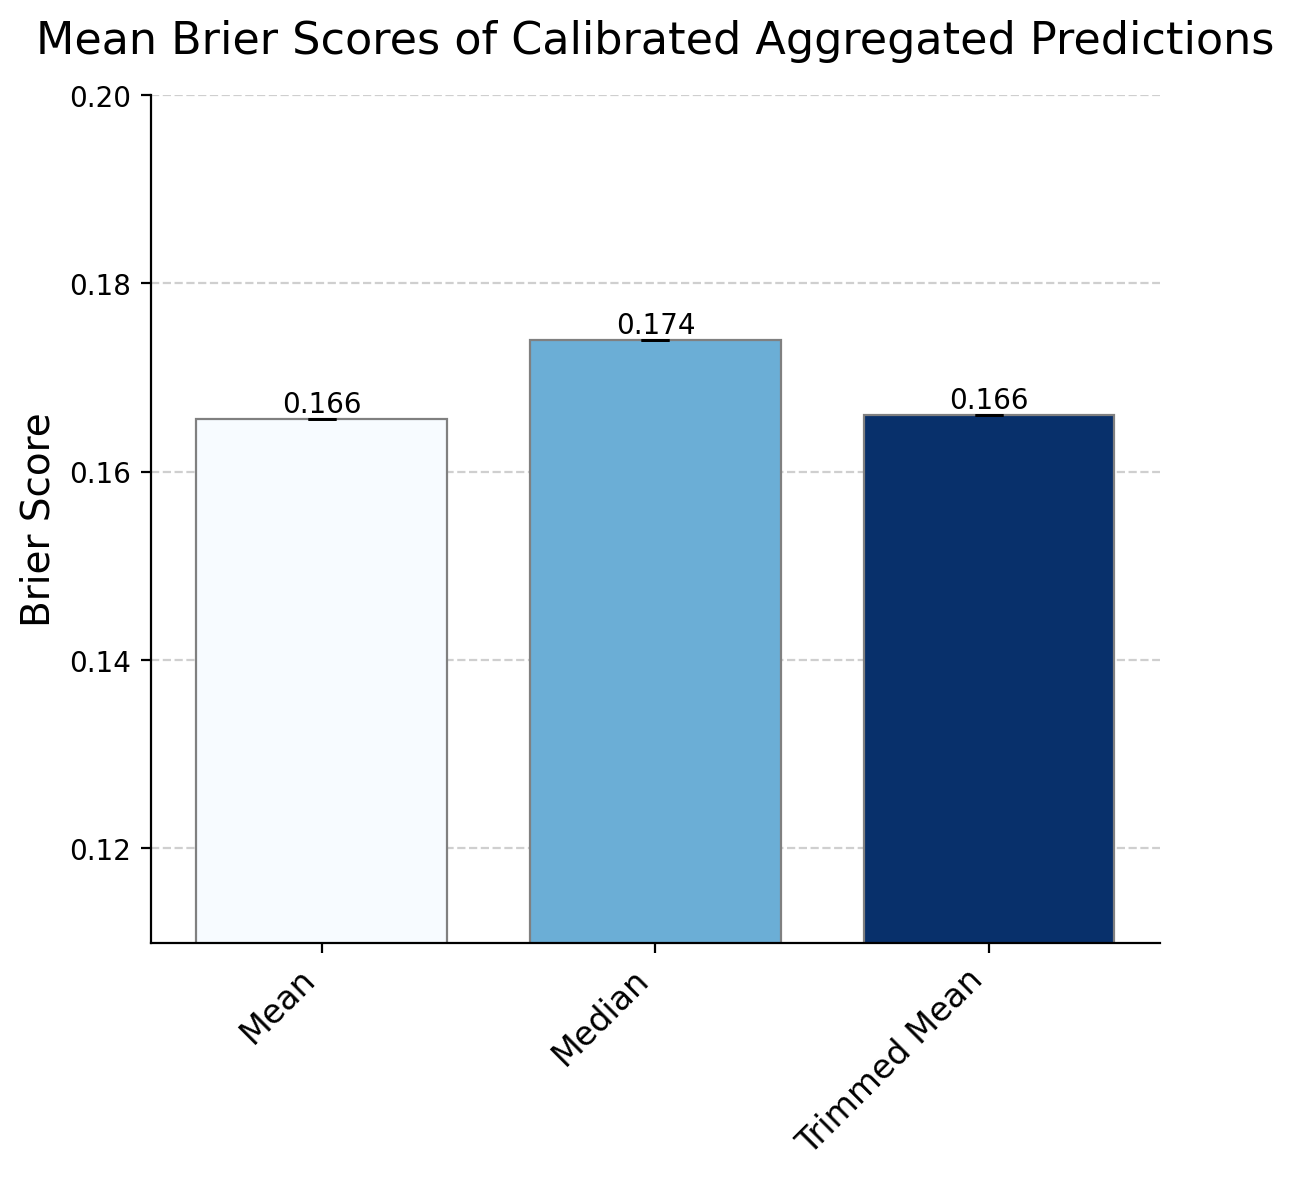

In [299]:
plot_bar_with_error(
    labels=["Mean", "Median", "Trimmed Mean"],
    means=[0.165625, 0.174048, 0.166040],
    sems=[0, 0, 0],
    title="Mean Brier Scores of Calibrated Aggregated Predictions",
    ylabel="Brier Score",
    ylim=(0.11, 0.20)
)

We see a shocking 0.165 brier score with calibrated demeaning aggregation! And an accuracy of 75%!

### Conclusions from metrics

The best pipeline is to aggregate the best models' predictions with a simple mean or with a trimmed mean and then calibrate these predictions to achieve a stunning Brier score of **0.165**. The accuracy achieved by this approach is 0.75, which is pretty high for the given level of uncertainty in question from polymarket.

The best model is by far the DeepSeek R1 model, followed by DeepSeekV3. Then come Mistral-3 and Gemini Flash.

The best way of aggregation is a trimmed mean across different models, which yields a brier score of 0.175. However, simple demeaning does not fall too far behind.

Results concerning the base rates: base rates show worse metrics (all three: brier, accuracy, auc-roc) than the enhanced inside view, supported by the base rate. However, the enriched predictions are worse than the standard ones, meaning that the base rates only confuse the model and it should be prompted with news only.

The results also suggest that individually calibrating the best model does not improve quality by much, but calibrating the aggregated predictions of several agents improves the final result not only in terms of the forecast confidence, but also its accuracy. This may come from the fact that some models specialize better in some categories of questions where others might lack expertise.

# Calibration curves

## Calibration curves

Let's have a look at how well our models are naturally calibrated and how their calibration can be improved

In [55]:
def plot_calibration_curve(y_true, y_pred, label, n_bins=5):
    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    true_fraction = [
        np.mean(y_true[(y_pred >= bin_edges[i]) & (y_pred < bin_edges[i+1])] == 1)
        for i in range(n_bins)
    ]
    plt.plot(bin_centers, true_fraction, marker='.', label=label, markersize=10, linewidth=2)
    


def plot_multiple_setups(df, setups, n_bins=5):
    plt.figure(figsize=(8, 6))
    for setup in setups:
        subset = df[
            (df['model'] == setup['model']) &
            (df['prompt_type'] == setup['prompt']) &
            (df['n_articles'] == setup['n_articles']) &
            (df['k'] == setup['k'])
        ]
        plot_calibration_curve(subset['true_label'], subset['probability_yes'], 
                               f"{setup['model']} | k={setup['k']}", n_bins)
    plt.plot([0, 1], [0, 1], 'k--', label='Perfect')
    plt.title("Calibration Curves Comparison", weight='bold')
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.legend()
    plt.ylim([-0.05, 1.05])
    plt.grid()
    plt.show()



def plot_time_evolution(df, model_name, prompt_type, n_articles, n_bins=10):
    plt.figure(figsize=(8, 7))
    for k in sorted(df['k'].unique()):
        subset = df[(df['model'] == model_name) & (df['prompt_type'] == prompt_type) & (df['k'] == k) & (df['n_articles'] == n_articles)]
        plot_calibration_curve(subset['true_label'], subset['probability_yes'], f"k={k}", n_bins)
    plt.plot([0, 1], [0, 1], 'k--', label='Perfect', linewidth=1.5)
    plt.title(f"Calibration Over Time for {model_name}", weight='bold')
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Mean Actual Outcome")
    plt.legend()
    plt.ylim([-0.05, 1.05])
    plt.grid(alpha=0.5, linestyle='--')
    plt.show()



def plot_before_after_calibration(df, setup, method='logistic', n_bins=10, test_size=0.3, random_state=None):
    subset = df[
        (df['model'] == setup['model']) &
        (df['prompt_type'] == setup['prompt']) &
        (df['n_articles'] == setup['n_articles']) &
        (df['k'] == setup['k'])
    ]
    y_true = subset['true_label'].values
    y_pred = subset['probability_yes'].values.reshape(-1, 1)

    X_train, X_test, y_train, y_test = train_test_split(
        y_pred, y_true,
        test_size=test_size,
        random_state=random_state
    )

    plot_calibration_curve(y_test, X_test.ravel(), 'Raw', n_bins)

    if method == 'logistic':
        calibrator = LogisticRegression()
        calibrator.fit(X_train, y_train)
        y_calibrated = calibrator.predict_proba(X_test)[:, 1]
    else:
        calibrator = IsotonicRegression(out_of_bounds='clip')
        calibrator.fit(X_train.ravel(), y_train)
        y_calibrated = calibrator.transform(X_test.ravel())

    plot_calibration_curve(y_test, y_calibrated, f'Calibrated', n_bins)

    plt.plot([0, 1], [0, 1], 'k--', label='Perfect')
    plt.title(f"Before vs After Calibration ({method})", weight='bold')
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.legend()
    plt.ylim([-0.05, 1.05])
    plt.grid(0.5, linestyle='--')
    plt.show()

Let's have a look at how calibration curves progress over time with the growth of prediction date $k\ \in (1, 2, 3, 4)$ :
$$\text{pred date}_k= \text{start date} + (\text{end date} - \text{start date} - 1) \cdot k/4$$

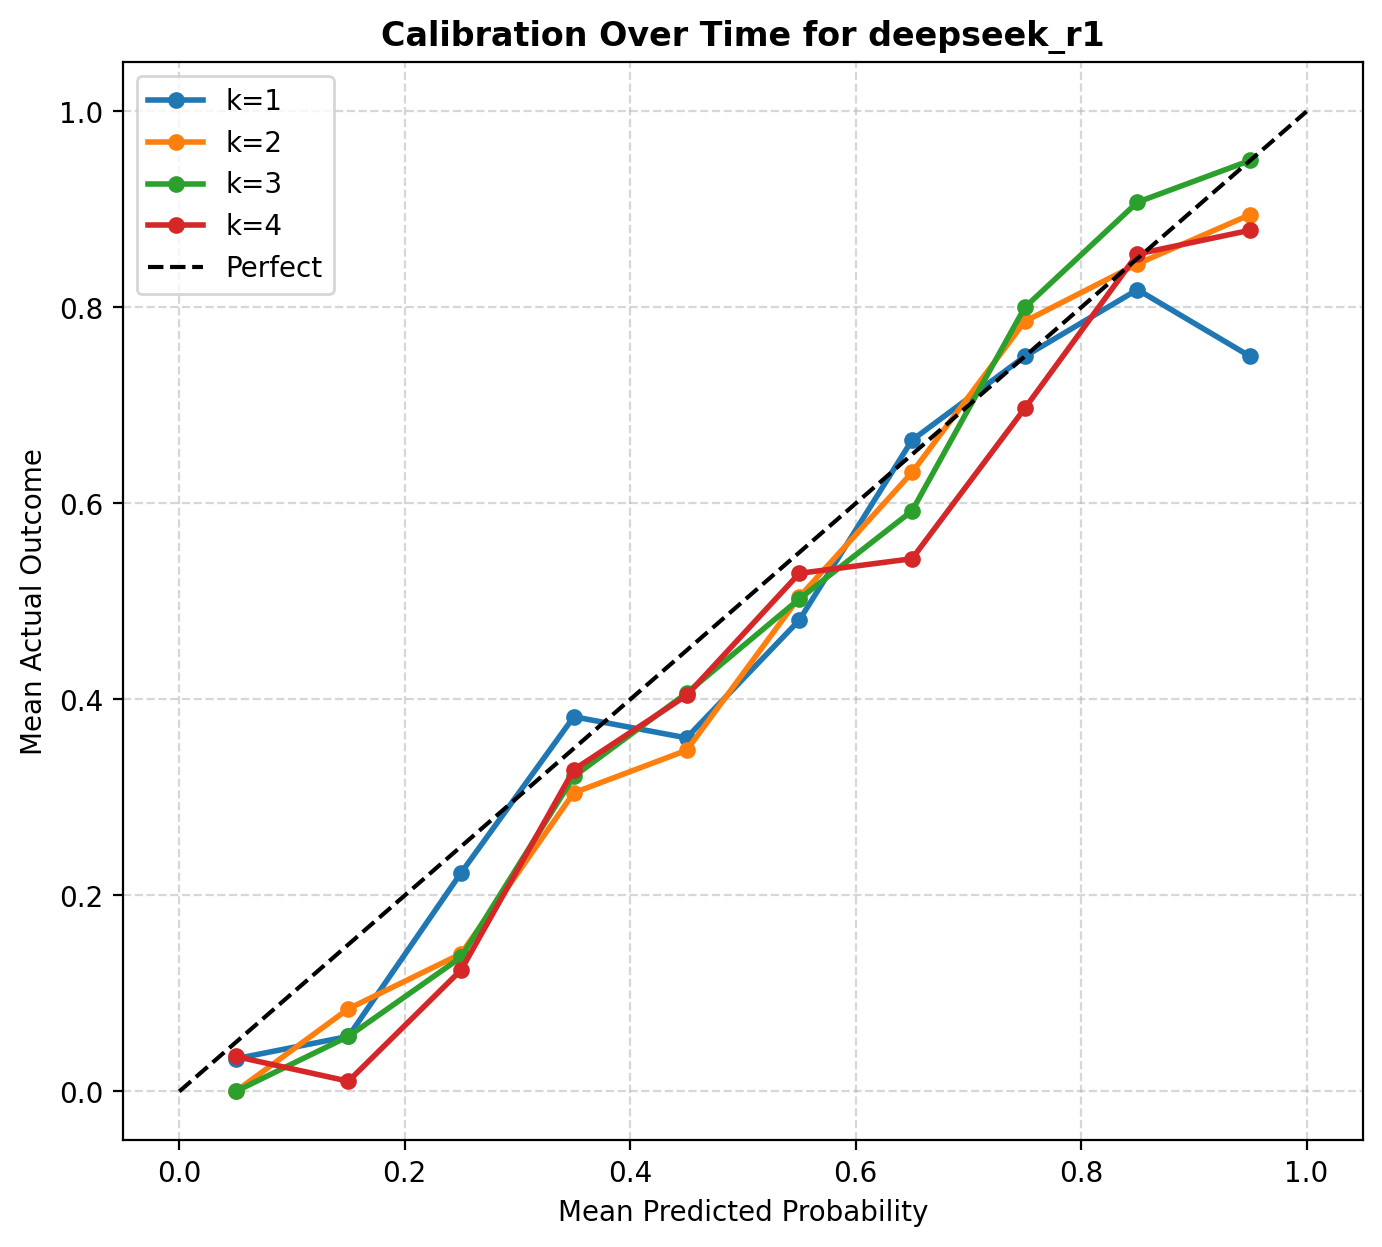

In [91]:
plot_time_evolution(df, "deepseek_r1", "basic_prompt", 10, 10)

We can see that DeepSeek R1 is naturally pretty well calibrated and is more or less stable through time.

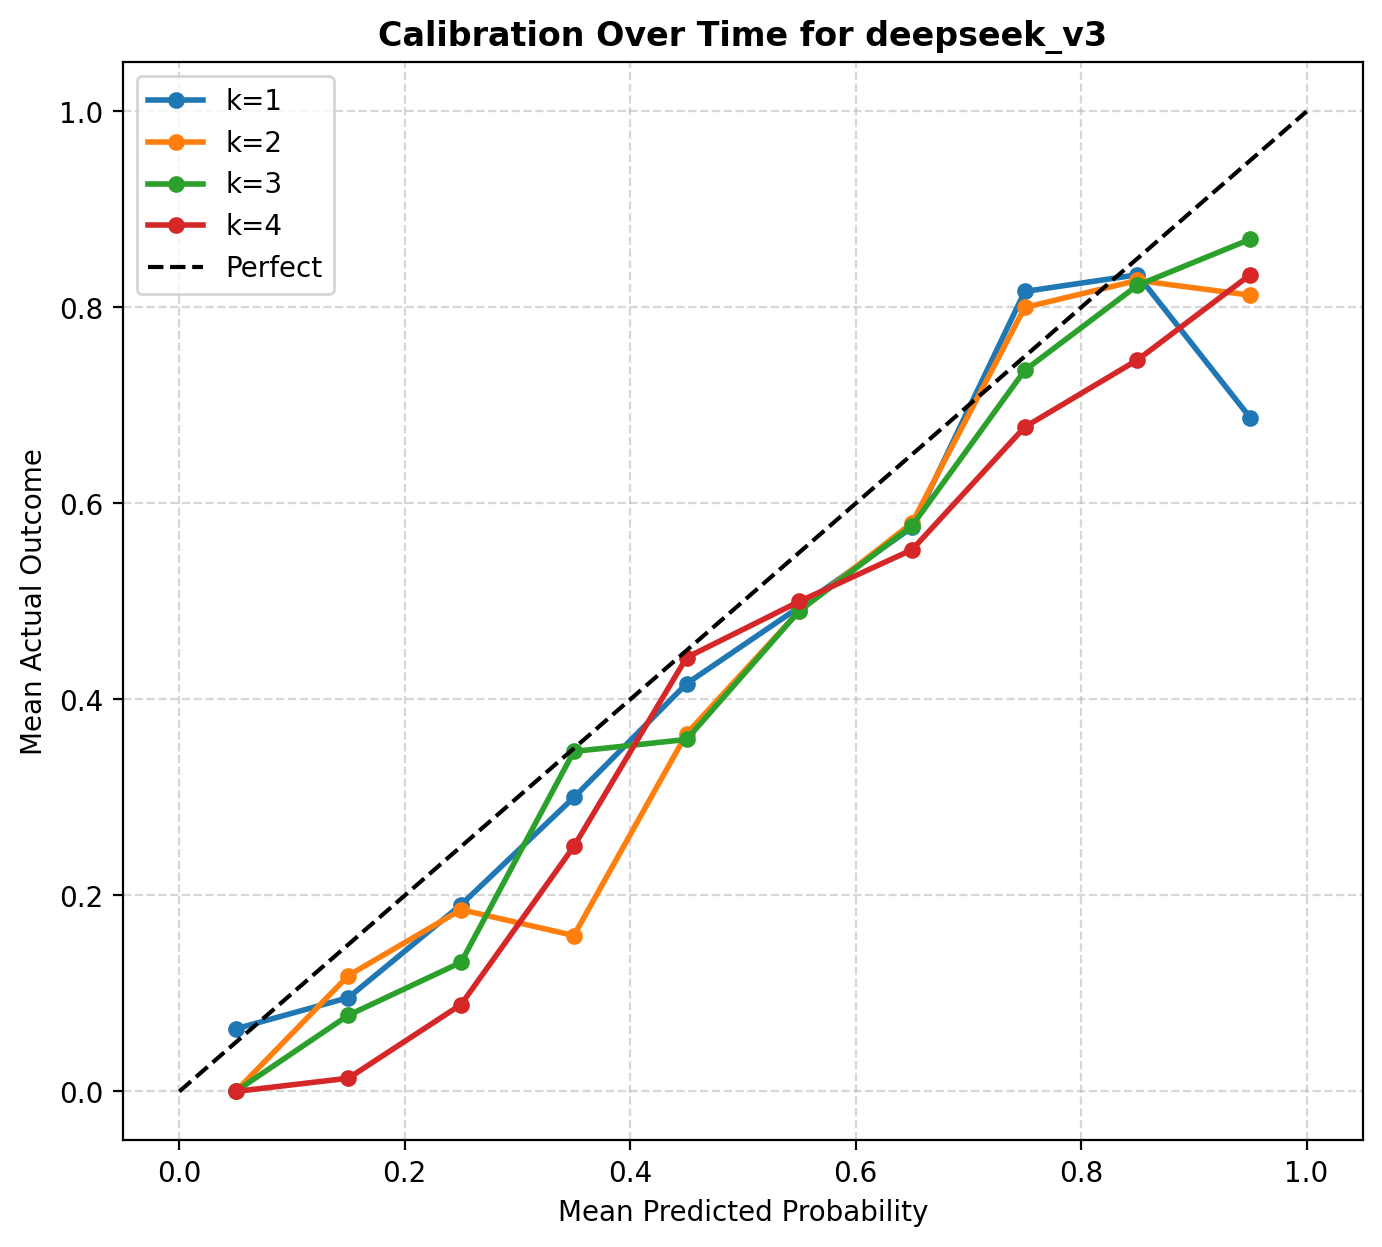

In [92]:
plot_time_evolution(df, "deepseek_v3", "champs_know", 15, n_bins=10)

We can see that DeepSeek R1 is naturally better calibrated than DeepSeek V3, which are the two top models in our setup. Deepseek V3 tends to be overconfident when stating the probabilities for events with 90-100% confidence

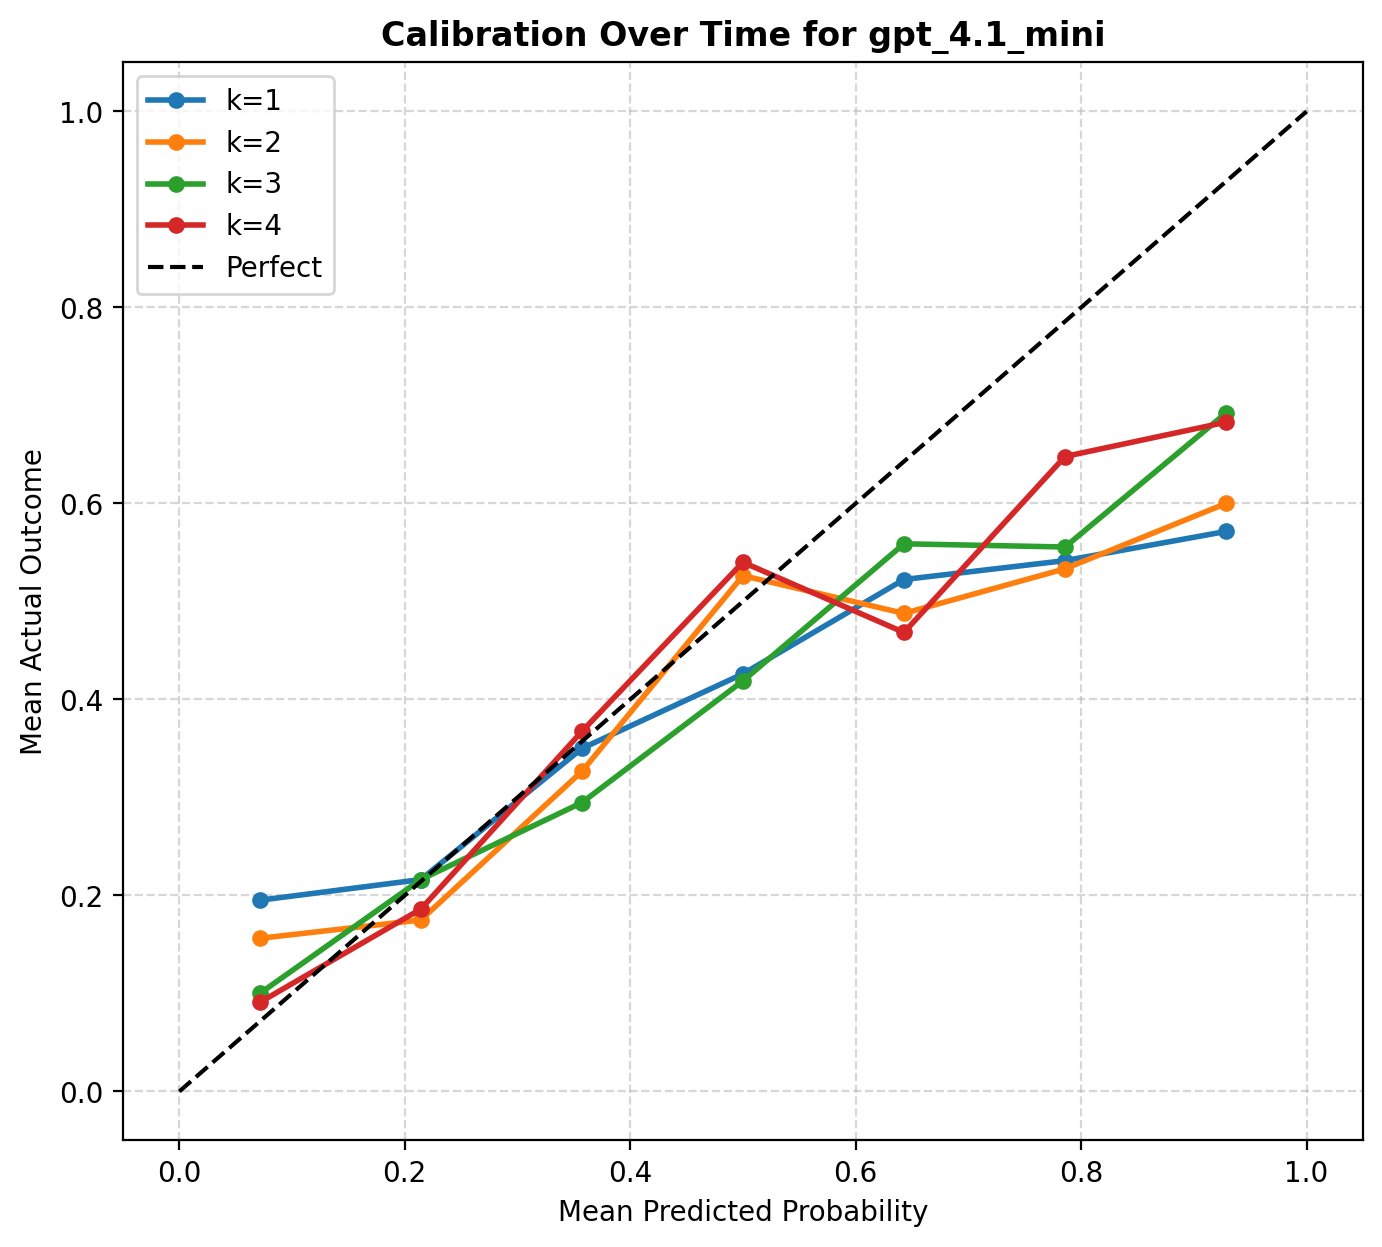

In [93]:
plot_time_evolution(df, "gpt_4.1_mini", "basic_prompt", 15, n_bins=7)

GPT 4.1 mini is an example of a model which is not well calibrated. This is seen on the calibration plot by the fact that its very often overly confident that the event will take place.

## Inside view VS Outside view

One interesting thing to look at is whether the stronger models can provide well calibrated forecasts without knowing the context and news data. This is called the "outside view" and it is contrary to the "inside view", in which case the model makes a forecast that is based on news context. 

In my experimental setup, I ask the model (DeepSeek R1, by far the strongest one) to give an outside view for the event and then enrich the inside data with the base rate.

It is interesting to see whether the base rates observed from the model are well calibrated at all or the model gives them on random.

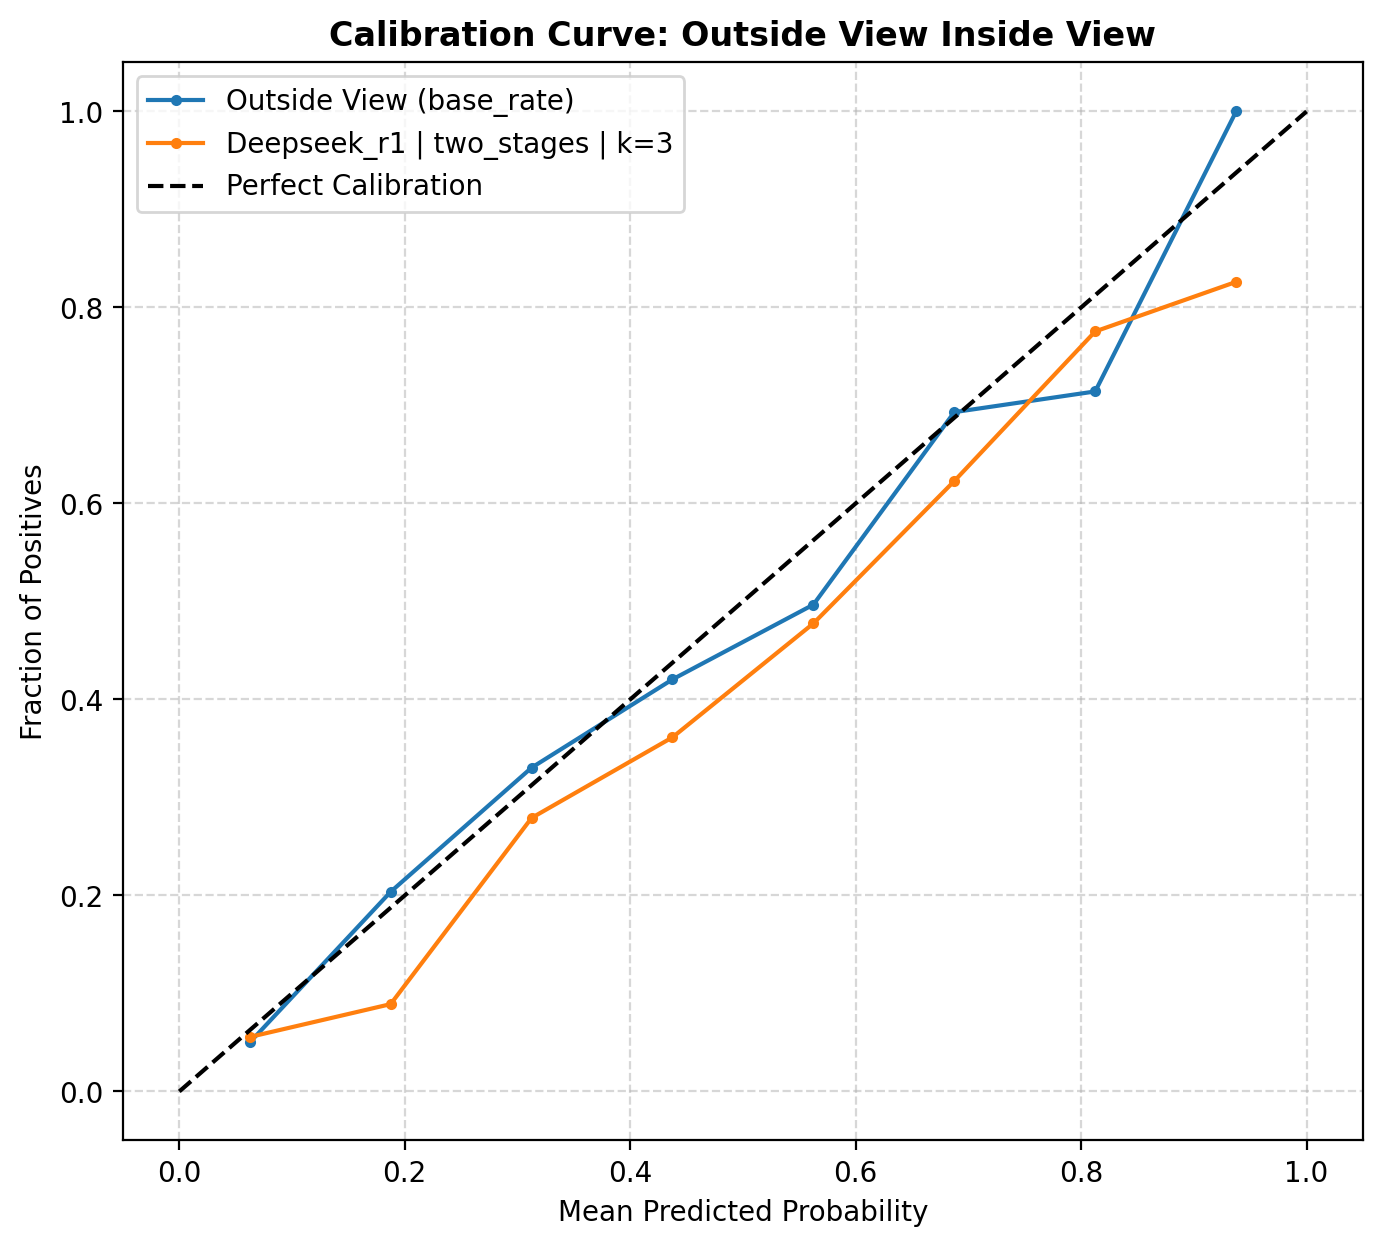

In [162]:
mask = (
    (df['model'] == 'deepseek_r1') &
    (df['prompt_type'] == 'two_stages') &
    (df['n_articles'] == 10) &
    (df['k'] == 3)
)
subset = df[mask]

y_true  = subset['true_label'].values
y_out   = subset['base_rate'].values
y_model = subset['probability_yes'].values


n_bins = 8
bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

def calc_fraction(y_true, y_pred):
    fractions = []
    for i in range(n_bins):
        sel = (y_pred >= bin_edges[i]) & (y_pred < bin_edges[i+1])
        if sel.sum() > 0:
            fractions.append(y_true[sel].mean())
        else:
            fractions.append(np.nan)
    return fractions

frac_out   = calc_fraction(y_true, y_out)
frac_model = calc_fraction(y_true, y_model)

plt.figure(figsize=(8,7))
plt.plot(bin_centers, frac_out,   marker='.', label='Outside View (base_rate)')
plt.plot(bin_centers, frac_model, marker='.', label='Deepseek_r1 | two_stages | k=3')
plt.plot([0, 1], [0, 1], 'k--',     label='Perfect Calibration')
plt.title('Calibration Curve: Outside View Inside View', weight='bold')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.ylim(-0.05, 1.05)
plt.grid(alpha=0.5, linestyle='--')
plt.legend()
plt.show()

Suprisingly, the model shows that its base rates are naturally well calibrated and in fact a little better than their enriched version.

## Calibrated VS Uncalibrated models examples
Now let's Have a look at how the models calibration can improve them on some examples:

DeepSeek R1

/Users/andreypetukhov/Documents/Thesis/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/andreypetukhov/Documents/Thesis/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


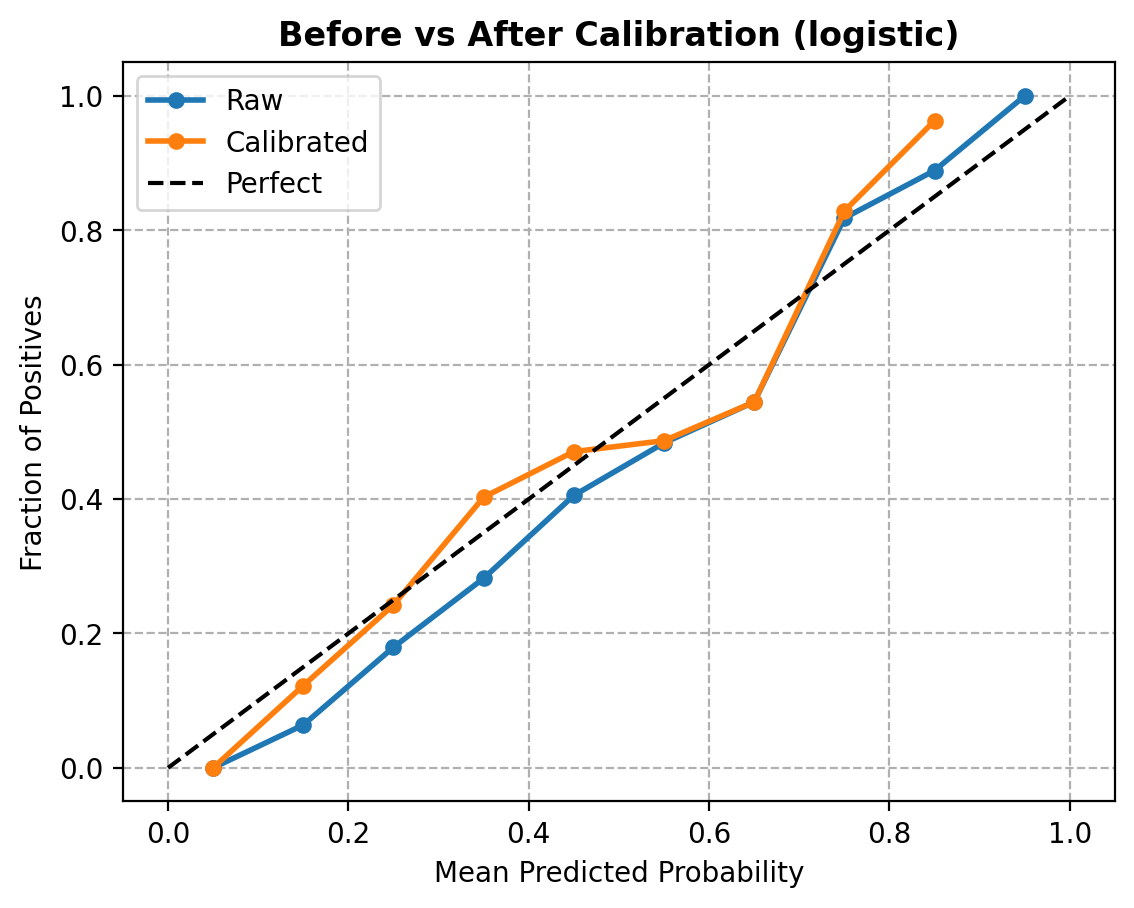

In [56]:
plot_before_after_calibration(df, setup={
    'model': 'deepseek_r1',
    'prompt': 'basic_prompt',
    'n_articles': 10,
    'k': 3
}, method='logistic', n_bins=10, test_size=0.5, random_state=42)

Due to the fact that the model is naturally calibrated on its own, calibration almost does not affect it. The plots do not look as smooth because the data has been split into the equal parts for this setup.

DeepSeek V3

/Users/andreypetukhov/Documents/Thesis/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/andreypetukhov/Documents/Thesis/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


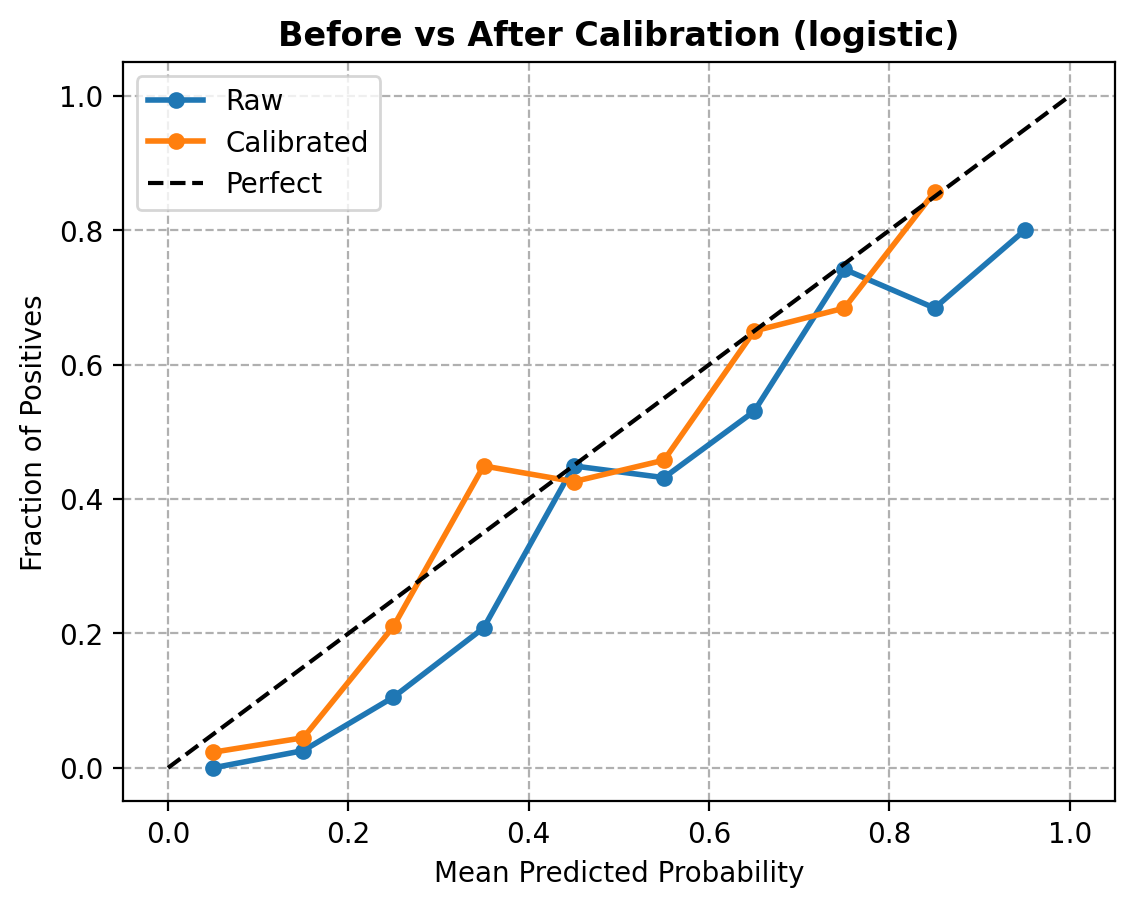

In [146]:
plot_before_after_calibration(df, setup={
    'model': 'deepseek_v3',
    'prompt': 'champs_know',
    'n_articles': 15,
    'k': 4
}, method='logistic', n_bins=10, test_size=0.5, random_state=42)

We can see that no matter the train-test split on our data, the calibration brings the models predictions a bit lower, meaning that the model by itself tennds to be overconfident

Mistral 3

/Users/andreypetukhov/Documents/Thesis/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/andreypetukhov/Documents/Thesis/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


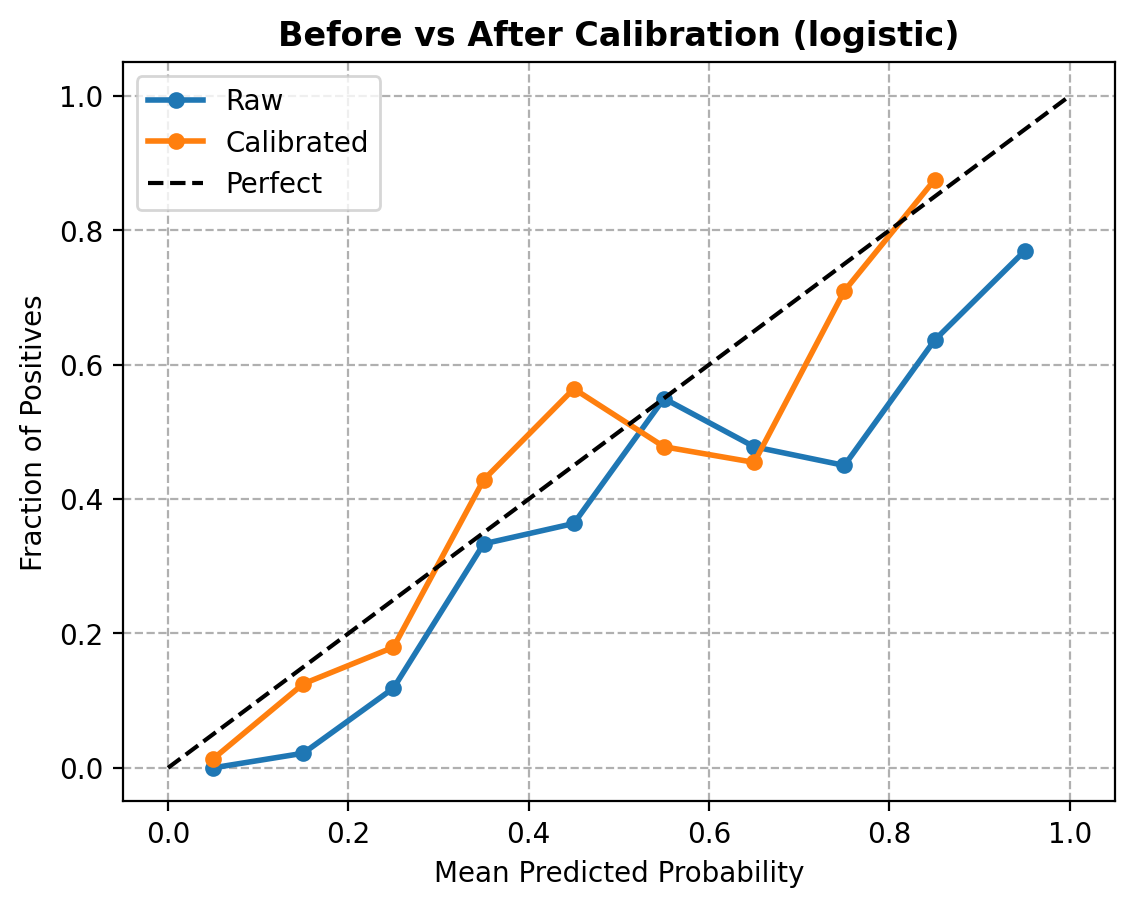

In [151]:
plot_before_after_calibration(
    df, 
    {'model': 'mistral_3', 'prompt': 'basic_prompt', 'n_articles': 10, 'k': 4},
    method='logistic', n_bins=10, test_size=0.5, random_state=42
)

Mistral is worse calibrated on the questions it's more certain about (predicted probability $\geq$ 70%), so it is more or less fixed by calibration

Gemini Flash

/Users/andreypetukhov/Documents/Thesis/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/andreypetukhov/Documents/Thesis/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


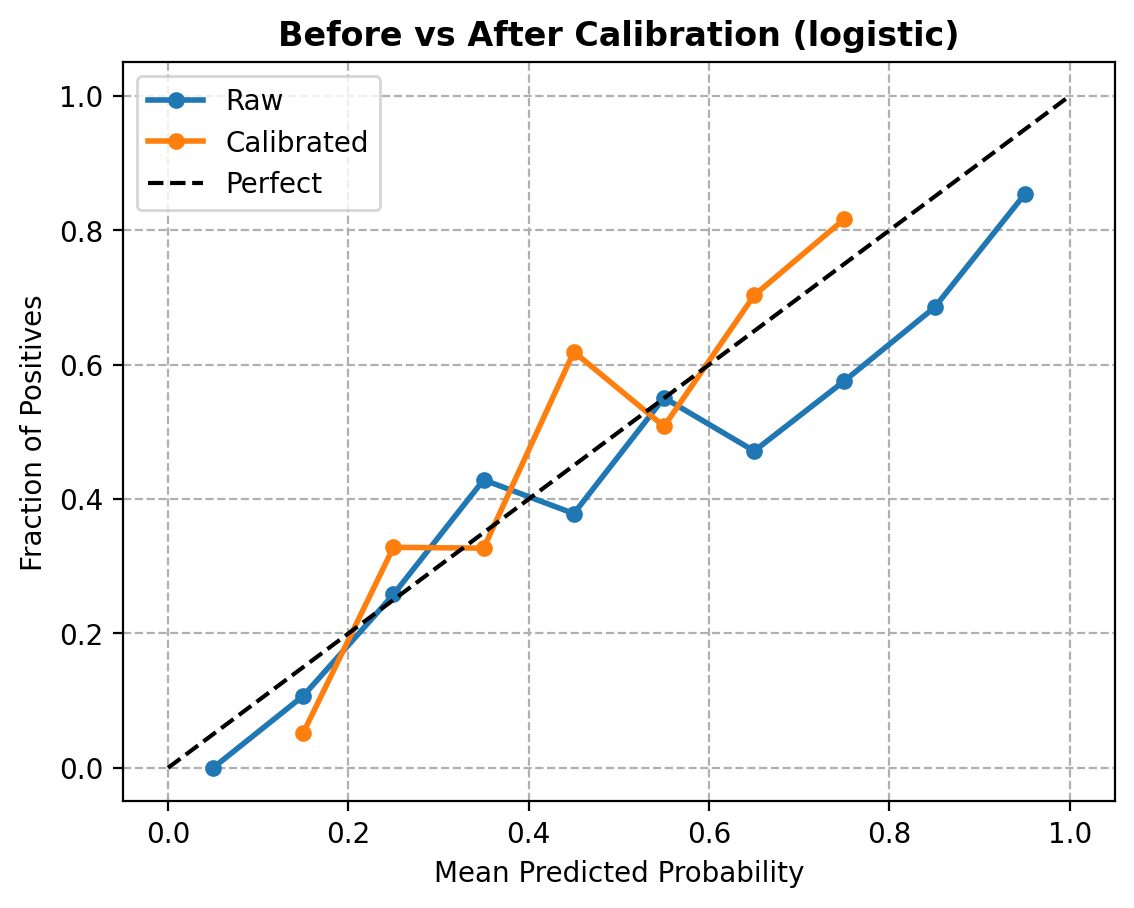

In [150]:
plot_before_after_calibration(
    df, 
    {'model': 'gemini_flash', 'prompt': 'basic_prompt', 'n_articles': 10, 'k': 4},
    method='logistic', n_bins=10, test_size=0.5, random_state=39
)

Calibration does not save Gemini Flash here, it is not well calibrated and cannot be calibrated to improve its performance on the calibration curve

## Various Aggregations of top models
Let's see how well the aggregated forecasts are

In [58]:
def plot_aggregation_calibration(df, setups, methods=None, n_bins=5):
    if methods is None:
        methods = ['mean', 'median', 'trimmed_mean', 'geometric_mean', 'quadratic_mean']

    subsets = []
    event_sets = []
    for s in setups:
        sub = df[
            (df['model'] == s['model']) &
            (df['prompt_type'] == s['prompt_type']) &
            (df['n_articles'] == s['n_articles']) &
            (df['k'] == s['k'])
        ]
        subsets.append(sub)
        event_sets.append(set(sub['event_id']))
    common_events = set.intersection(*event_sets)
    if not common_events:
        raise ValueError("No common events found across the provided setups.")
    
    probs_list = []
    for sub in subsets:
        subc = sub[sub['event_id'].isin(common_events)].copy()
        subc.sort_values('event_id', inplace=True)
        probs_list.append(subc['probability_yes'].values)
    y_true = subc['true_label'].values
    arr = np.vstack(probs_list)
    
    def trimmed_mean_func(x):
        if x.shape[0] > 2:
            x_sorted = np.sort(x, axis=0)
            return np.mean(x_sorted[1:-1, :], axis=0)
        else:
            return np.mean(x, axis=0)
    
    agg_funcs = {
        'mean': lambda x: np.mean(x, axis=0),
        'median': lambda x: np.median(x, axis=0),
        'trimmed_mean':   trimmed_mean_func,
        'geometric_mean': lambda x: np.exp(np.mean(np.log(x + 1e-9), axis=0)),
        'quadratic_mean': lambda x: np.sqrt(np.mean(x**2, axis=0)),
    }

    bin_edges   = np.linspace(0.0, 1.0, n_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    plt.figure(figsize=(8,6))
    for m in methods:
        if m not in agg_funcs:
            raise ValueError(f"Неизвестный метод агрегации: {m}")
        agg_preds = agg_funcs[m](arr)
        
        fractions = []
        for i in range(n_bins):
            mask = (agg_preds >= bin_edges[i]) & (agg_preds < bin_edges[i+1])
            fractions.append(np.mean(y_true[mask]) if mask.sum()>0 else np.nan)
        
        plt.plot(bin_centers, fractions, marker='.', label=m)
    
    plt.plot([0,1], [0,1], 'k--', label='Perfect')
    plt.title("Aggregated Calibration Curves", weight='bold')
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.ylim(-0.05, 1.05)
    plt.grid(alpha=0.5, linestyle='--')
    plt.legend()
    plt.show()

Aggregated calibration curves across the strongest setups must yield

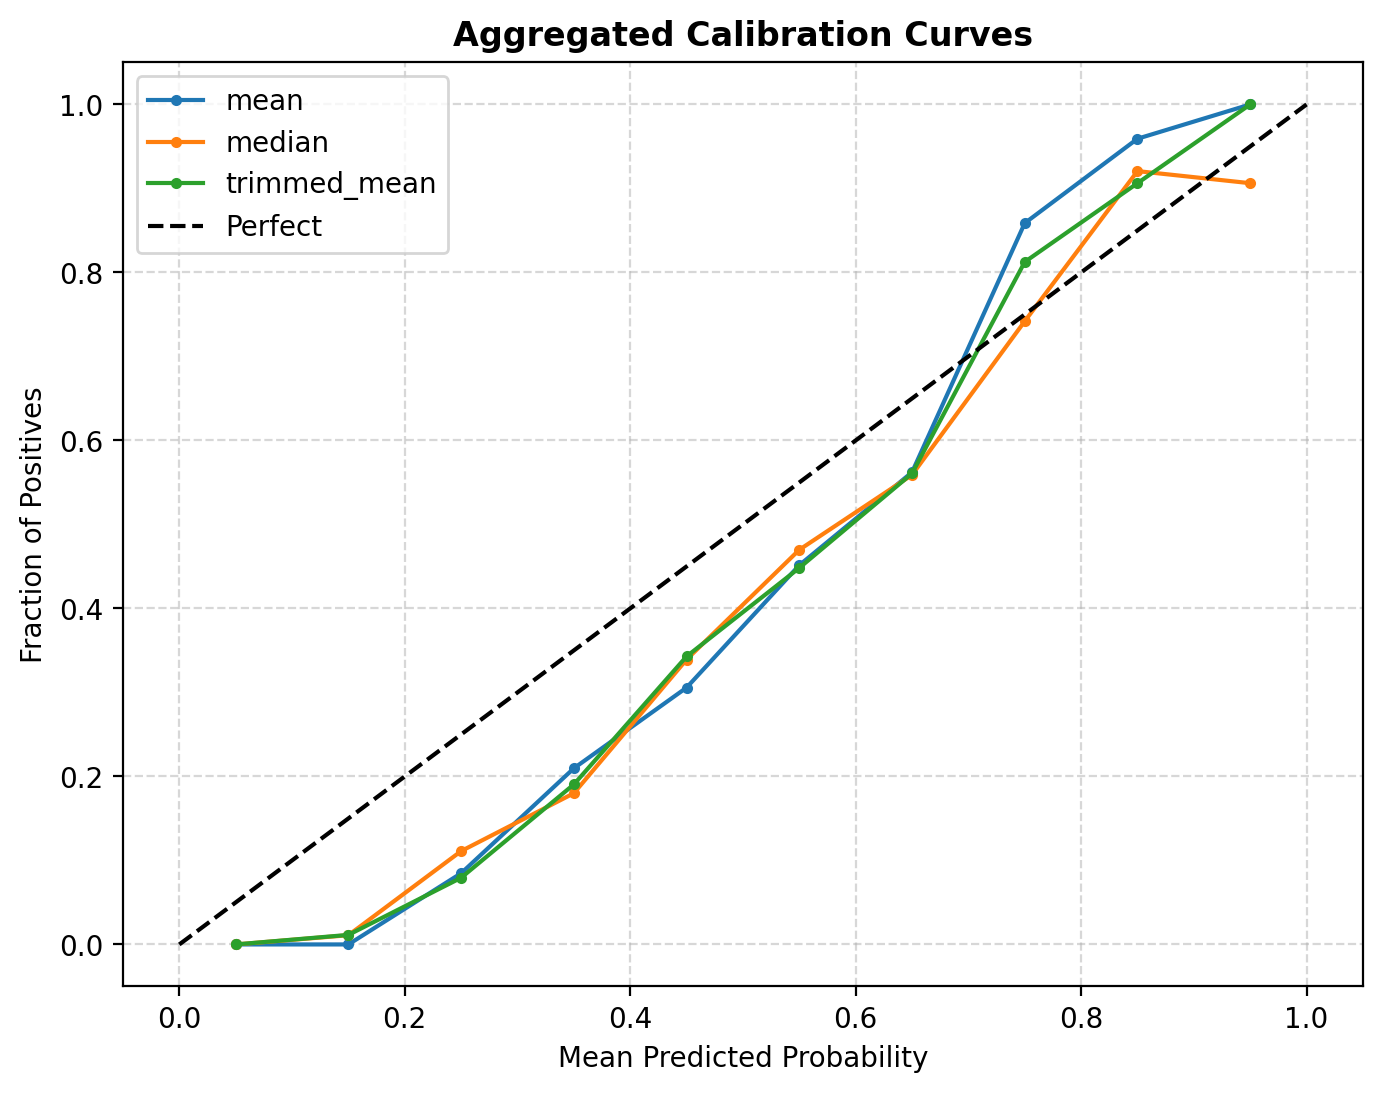

In [173]:
plot_aggregation_calibration(df, setups=[
    {'model': 'deepseek_r1', 'prompt_type': 'basic_prompt', 'n_articles': 10, 'k': 4},
    {'model': 'deepseek_r1', 'prompt_type': 'two_stages', 'n_articles': 10, 'k': 3},
    {'model': 'deepseek_v3', 'prompt_type': 'champs_know', 'n_articles': 15, 'k': 4},
    {'model': 'deepseek_v3', 'prompt_type': 'champs_know', 'n_articles': 15, 'k': 3},
    {'model': 'mistral_3', 'prompt_type': 'basic_prompt', 'n_articles': 10, 'k': 4},
    {'model': 'gemini_flash', 'prompt_type': 'basic_prompt', 'n_articles': 10, 'k': 4},
],
methods=["mean", "median", "trimmed_mean"], n_bins=10)

All the calibration methods yield very similar results, showing that the aggreagted forecasts are a little underconfident, so with calibration they can be significantly improved, which we have seen in the section above, where the aggregated stats showed the highest metrics

# Other

Auxilary charts not so relevant to the research

Let's see how the number of retrieved articles affects the quality of predictions

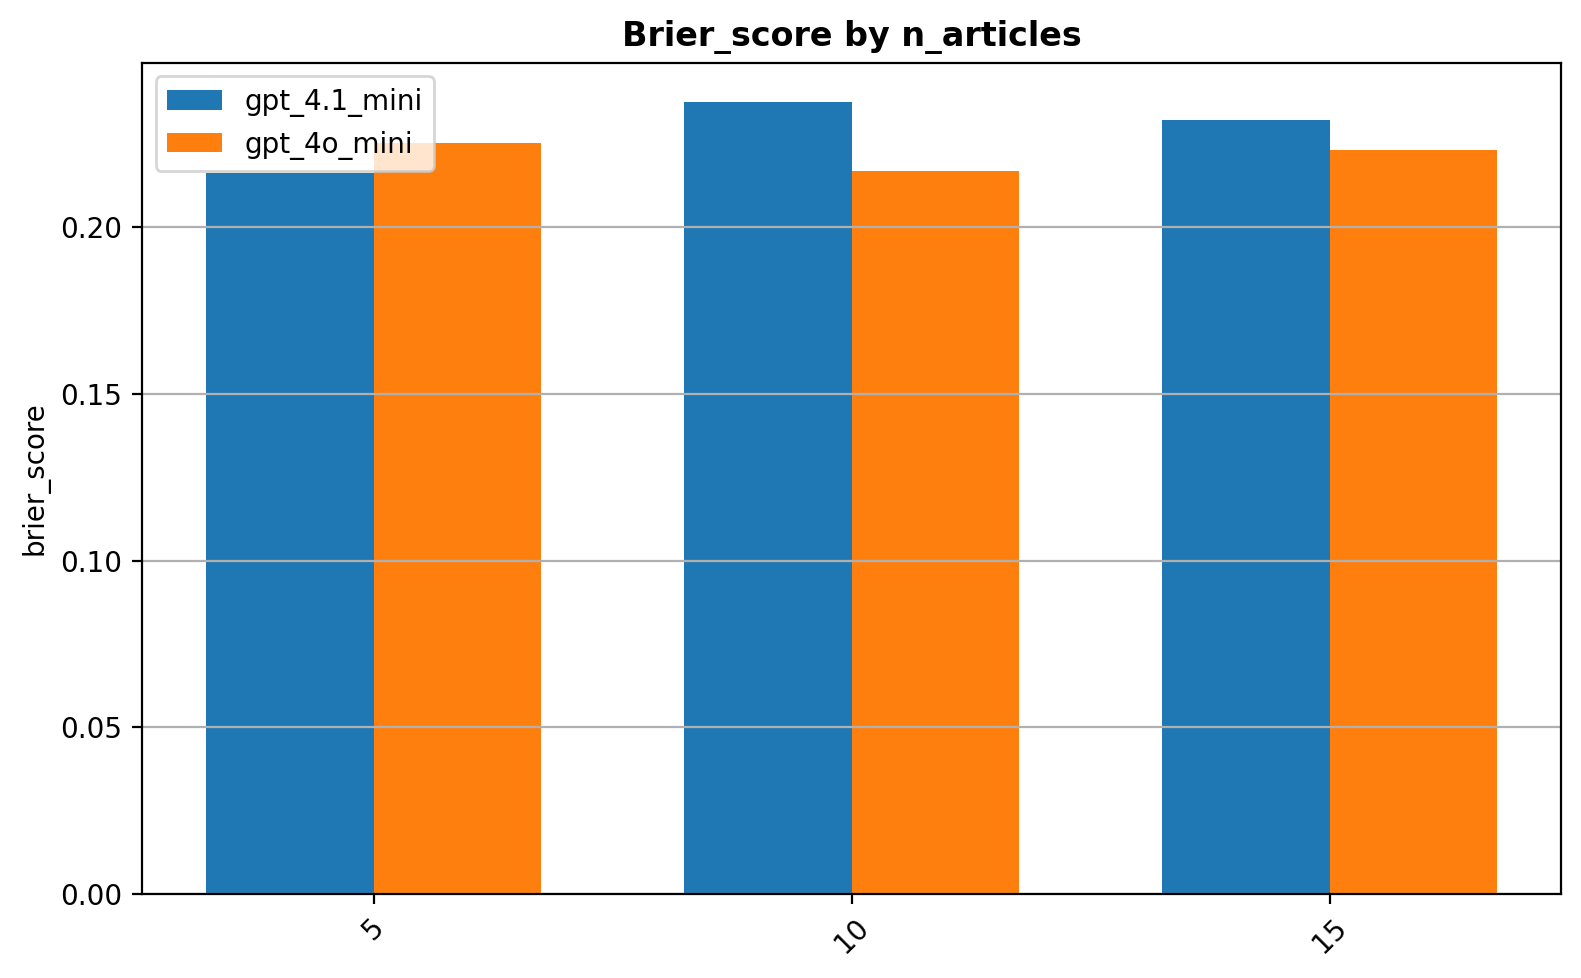

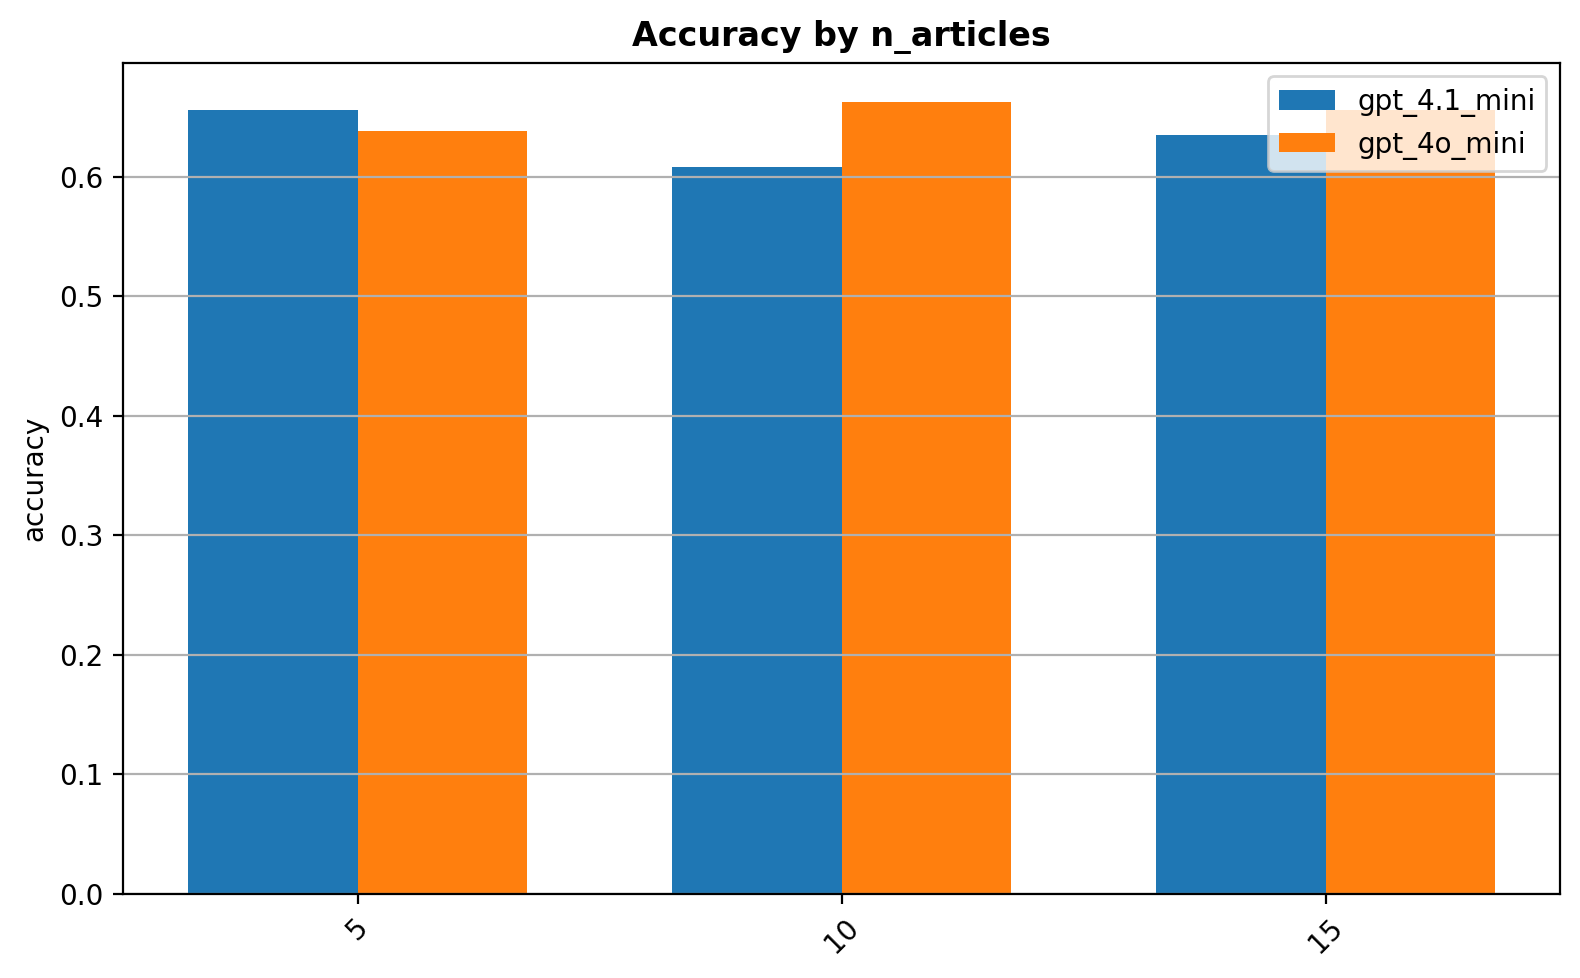

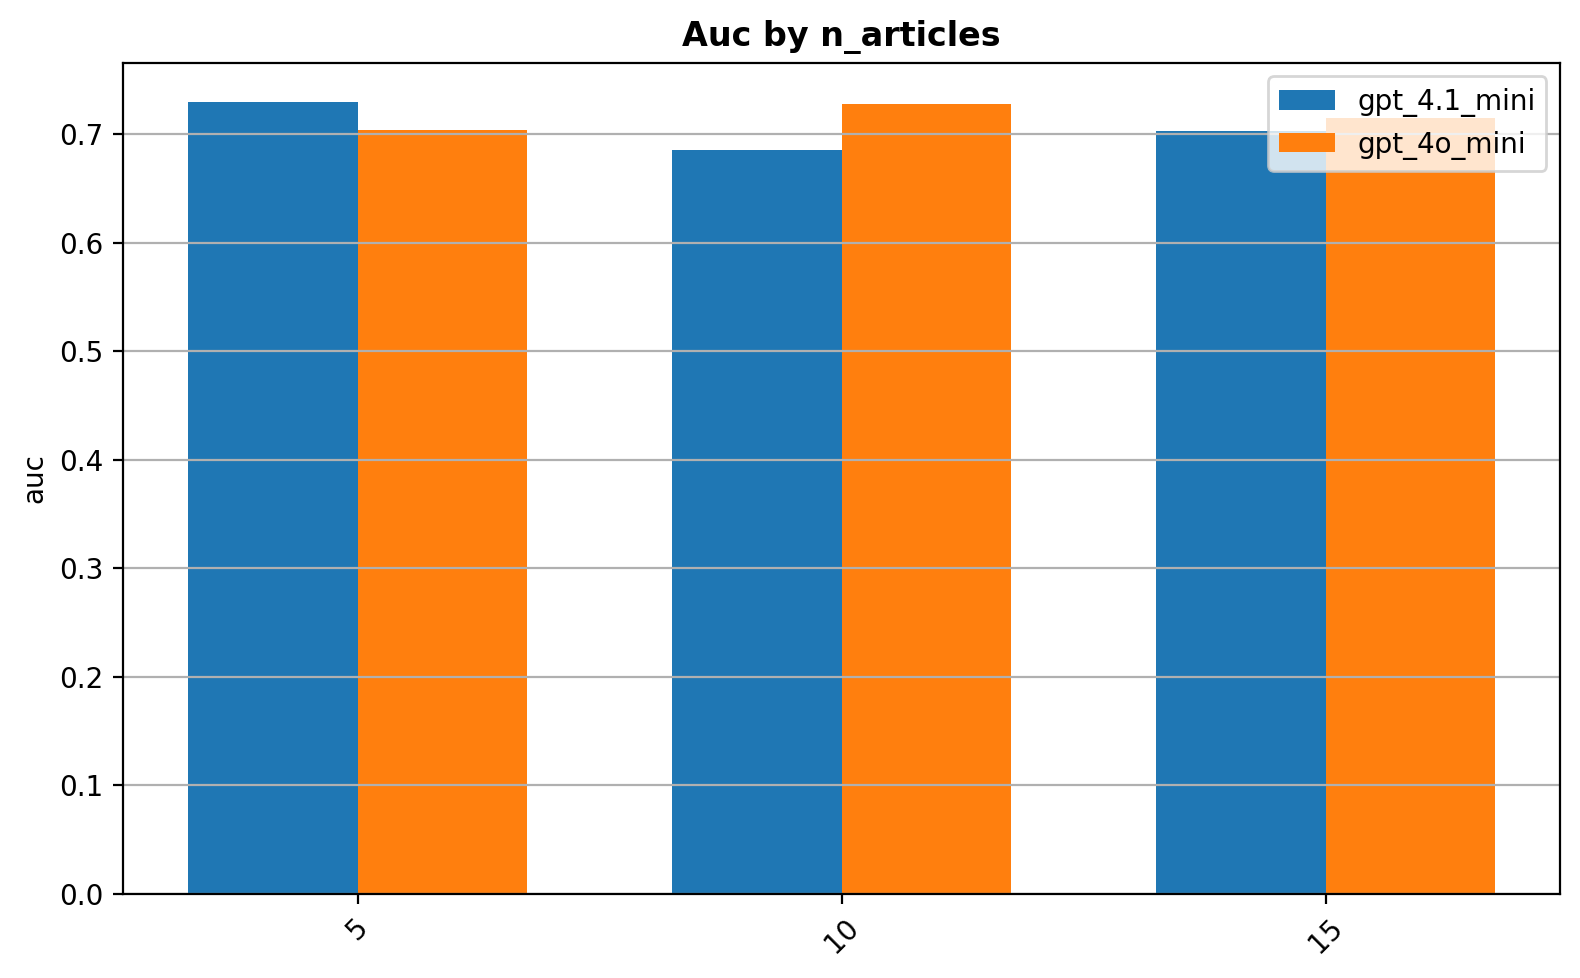

In [239]:
plot_models_by_factor(df, ['gpt_4.1_mini','gpt_4o_mini'], 'n_articles', [5,10,15])

There is no consistent pattern across the number of retrieved articels

Now let's have a look at how the prompt type affects our metrics

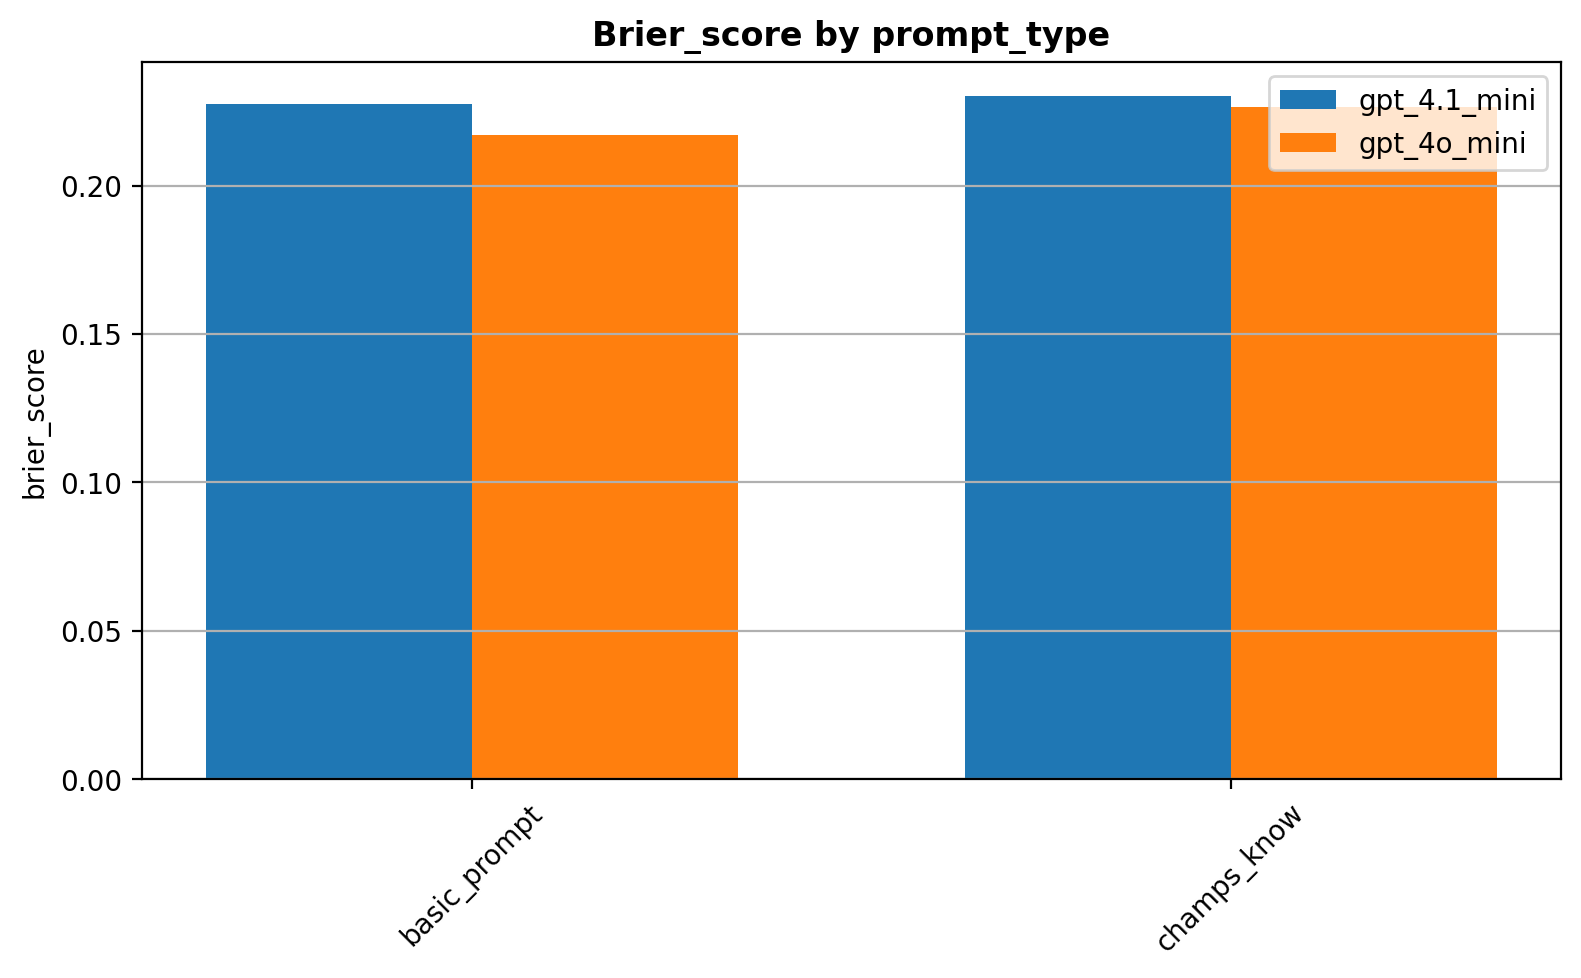

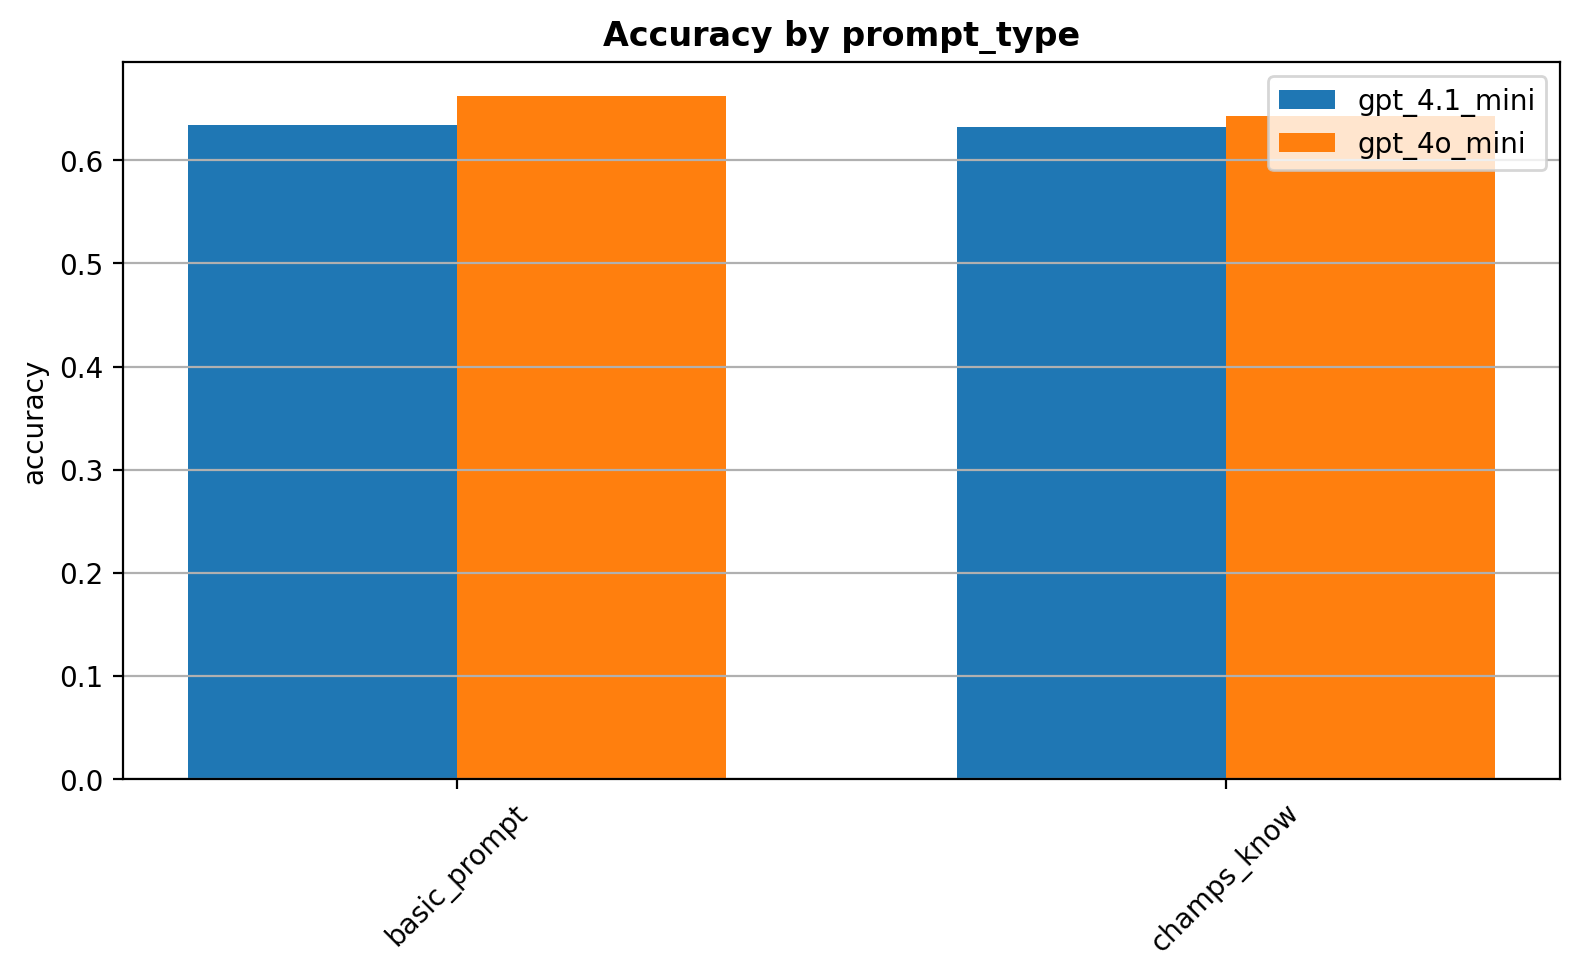

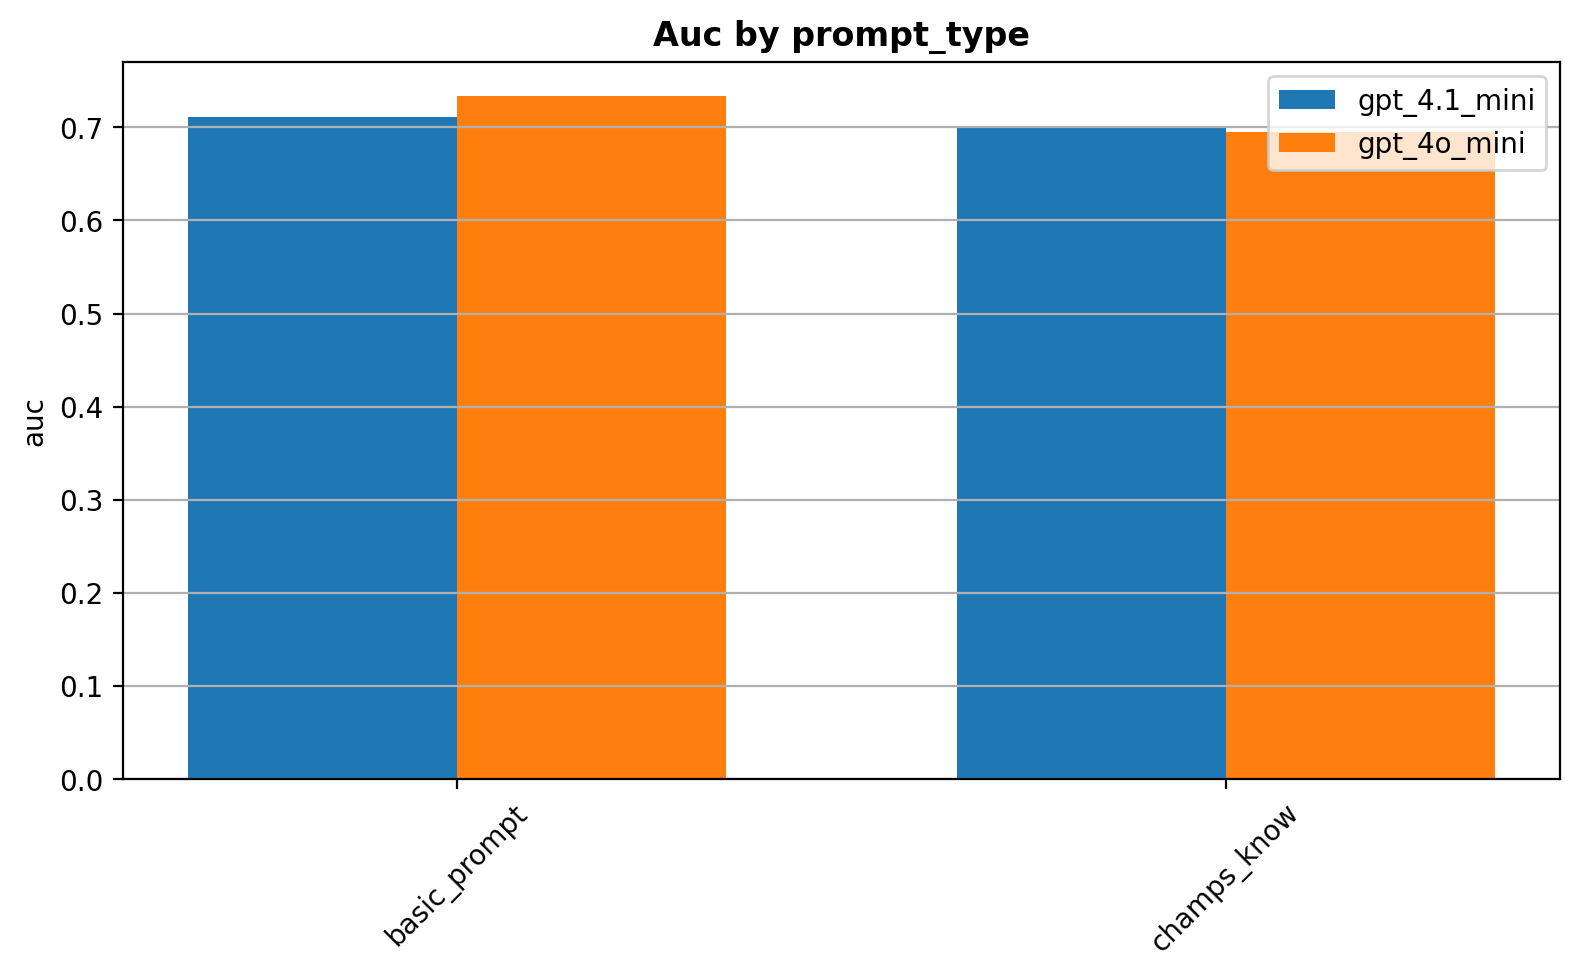

In [240]:
plot_models_by_factor(df, ['gpt_4.1_mini','gpt_4o_mini'], 'prompt_type', ["basic_prompt", "champs_know"])

Basic prompt and CHAMPS KNOW prompt yield almost the same results for the smaller models in my setups

In [149]:
class CategoryEncoder(BaseEstimator, TransformerMixin):
    """
    One-hot encode a 'categories' column containing stringified lists per event.
    """
    def __init__(self):
        self.mlb = MultiLabelBinarizer()

    def fit(self, X, y=None):
        lists = X.squeeze().apply(lambda s: ast.literal_eval(s) if isinstance(s, str) else s)
        self.mlb.fit(lists)
        return self

    def transform(self, X):
        lists = X.squeeze().apply(lambda s: ast.literal_eval(s) if isinstance(s, str) else s)
        arr = self.mlb.transform(lists)
        return pd.DataFrame(arr, columns=self.mlb.classes_, index=X.index)


def train_single_model_aggregator(df, model_name, prompt_type=None, test_size=0.2, random_state=42):
    mask = df['model'] == model_name
    if prompt_type is not None:
        mask &= df['prompt_type'] == prompt_type
    df_model = df[mask].copy()

    df_u = df_model.drop_duplicates('event_id').set_index('event_id')

    pivot = df_model.pivot(index='event_id', columns='k', values='probability_yes')
    pivot = pivot.rename(columns=lambda c: f"pred_k{c}")
    X = pivot.join(df_u[['num_articles_used']])

    cat_enc = CategoryEncoder()
    cat_feats = cat_enc.fit_transform(df_u[['categories']])
    X = X.join(cat_feats)
    y = df_u['true_label']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    num_cols = [c for c in X.columns if c.startswith('pred_k') or c == 'num_articles_used']
    num_pipeline = Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        ('scale', StandardScaler())
    ])
    preproc = ColumnTransformer([
        ('num', num_pipeline, num_cols)
    ], remainder='passthrough')

    pipe = Pipeline([
        ('prep', preproc),
        ('clf', LogisticRegression(max_iter=500, C=0.1))
    ])
    pipe.fit(X_train, y_train)

    y_prob = pipe.predict_proba(X_test)[:, 1]
    y_pred = pipe.predict(X_test)

    metrics = {
        'brier': brier_score_loss(y_test, y_prob),
        'accuracy': accuracy_score(y_test, y_pred),
        'auc': roc_auc_score(y_test, y_prob)
    }
    preds_df = pd.DataFrame({'event_id': X_test.index, 'y_true': y_test,
                              'y_pred_prob': y_prob, 'y_pred': y_pred}).reset_index(drop=True)
    return preds_df, metrics


def train_multi_model_aggregator(df, model_list, test_size=0.2, random_state=42):
    df_u = df.drop_duplicates('event_id').set_index('event_id')
    frames = []
    for m in model_list:
        tmp = df[df['model'] == m]
        piv = tmp.pivot(index='event_id', columns='k', values='probability_yes')
        piv = piv.rename(columns=lambda c: f"{m}_pred_k{c}")
        frames.append(piv)
    X = pd.concat(frames, axis=1)

    if 'two_stages' in df_u['setup'].unique():
        X = X.join(df_u['base_rate'])

    cat_enc = CategoryEncoder()
    cat_feats = cat_enc.fit_transform(df_u[['categories']])
    X = X.join(cat_feats)
    y = df_u['true_label']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    num_cols = [c for c in X.columns if 'pred_k' in c or c in ('num_articles_used','base_rate')]
    num_pipe = Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        ('scale', StandardScaler())
    ])
    preproc = ColumnTransformer([('num', num_pipe, num_cols)], remainder='passthrough')
    pipe = Pipeline([('prep', preproc), ('clf', LogisticRegression(max_iter=1000))])
    pipe.fit(X_train, y_train)
    y_prob = pipe.predict_proba(X_test)[:, 1]
    y_pred = pipe.predict(X_test)
    metrics = {'brier': brier_score_loss(y_test, y_prob),
               'accuracy': accuracy_score(y_test, y_pred),
               'auc': roc_auc_score(y_test, y_prob)}
    preds_df = pd.DataFrame({'event_id': X_test.index, 'y_true': y_test,
                              'y_pred_prob': y_prob, 'y_pred': y_pred}).reset_index(drop=True)
    return preds_df, metrics

preds_df, metrics = train_single_model_aggregator(df, "deepseek_r1", "basic_prompt", test_size=0.4, random_state=1)
metrics

{'brier': 0.2462357560281516, 'accuracy': 0.575, 'auc': 0.48705141012833325}

Trainable Logistic aggregation only worsens the initial model's forecasts and moves them towards random. This can be explained by the scarcity of training data. With larger datasets of predictions it would be possible to train the models on features like TF-IDF representations of the titles or descriptions, not only one-hot encoded categories and probabilities of the model through time.

# TODO

1) Карта с гео и предсказываемостью по геолокации
2) Таблица с качеством предсказаний в срезах по различным категориям (мб в виде heatmap?)
3) Графики с описанием данных
4) Графики с распредлеением предсказаний основной модели

In [ ]:
data["end_date"]

20231228183748

In [148]:
data = df[['event_id', 'model', 'prompt_type', 'n_articles', 'k', 'setup', 'true_label', 'probability_yes', 'brier_score', 'categories']].copy()
data = data[(data["model"].isin(["deepseek_r1", "deepseek_v3", "mistral_3", "gemini_flash"])) & (data["k"] == 3)]

In [149]:
import pandas as pd
import ast # Модуль для безопасного вычисления строковых литералов Python

# --- Начало решения ---

# 2. Преобразование строковых представлений списков в настоящие списки
#    Используем ast.literal_eval для безопасности.
#    Добавим обработку ошибок для случаев, когда значение не является корректным списком или NaN/None.
def safe_literal_eval(val):
    if pd.isna(val) or not isinstance(val, str):
        return [] # Возвращаем пустой список для NaN или некорректных типов
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return [] # Возвращаем пустой список, если строка не может быть разобрана

data['categories_list'] = data['categories'].apply(safe_literal_eval)

# 3. "Разворачивание" (explode) DataFrame по спискам категорий
# Каждая категория из списка 'categories_list' создаст новую строку
df_exploded = data.explode('categories_list')

# После explode, строки с изначально пустыми списками категорий будут иметь NaN
# в 'categories_list'. Их можно удалить, если они не нужны для анализа.
# Или заменить NaN на какое-то значение типа "no_category", если это имеет смысл.
# В данном случае, мы хотим статистику по *конкретным* категориям,
# так что строки без категорий (где categories_list станет NaN после explode) нам не нужны.
df_exploded = df_exploded.dropna(subset=['categories_list'])

# Переименуем колонку для ясности
df_exploded = df_exploded.rename(columns={'categories_list': 'category'})

# 4. Группировка по 'setup' и 'category' и вычисление среднего Brier Score
result_table = df_exploded.groupby(['setup', 'category'])['brier_score'].mean().reset_index()

# Можно переименовать колонку с Brier Score для понятности
result_table = result_table.rename(columns={'brier_score': 'mean_brier_score'})

# 5. (Опционально) Представление в виде сводной таблицы для наглядности
#    где категории - это колонки, а сетапы - строки
pivot_table = result_table.pivot_table(
    index='setup',
    columns='category',
    values='mean_brier_score'
)

# # --- Конец решения ---

# print("Исходный DataFrame:")
# print(data)
# print("\nDataFrame после explode:")
# print(df_exploded[['setup', 'category', 'brier_score']])
# print("\nРезультат (средний Brier Score по setup и category):")
# print(result_table)
# print("\nРезультат в виде сводной таблицы:")
# print(pivot_table)


In [168]:
df_exploded["category"].value_counts()

category
Sports         3214
Politics       1010
Election        650
Crypto          345
Business        285
Culture         285
Finance         270
Geopolitics     250
Other           180
Military        175
War             135
Technology      135
Economics        60
Mentions         45
Science          45
Healthcare       30
Research         25
Law              15
Education        10
Music             5
Environment       5
Biology           5
Name: count, dtype: int64

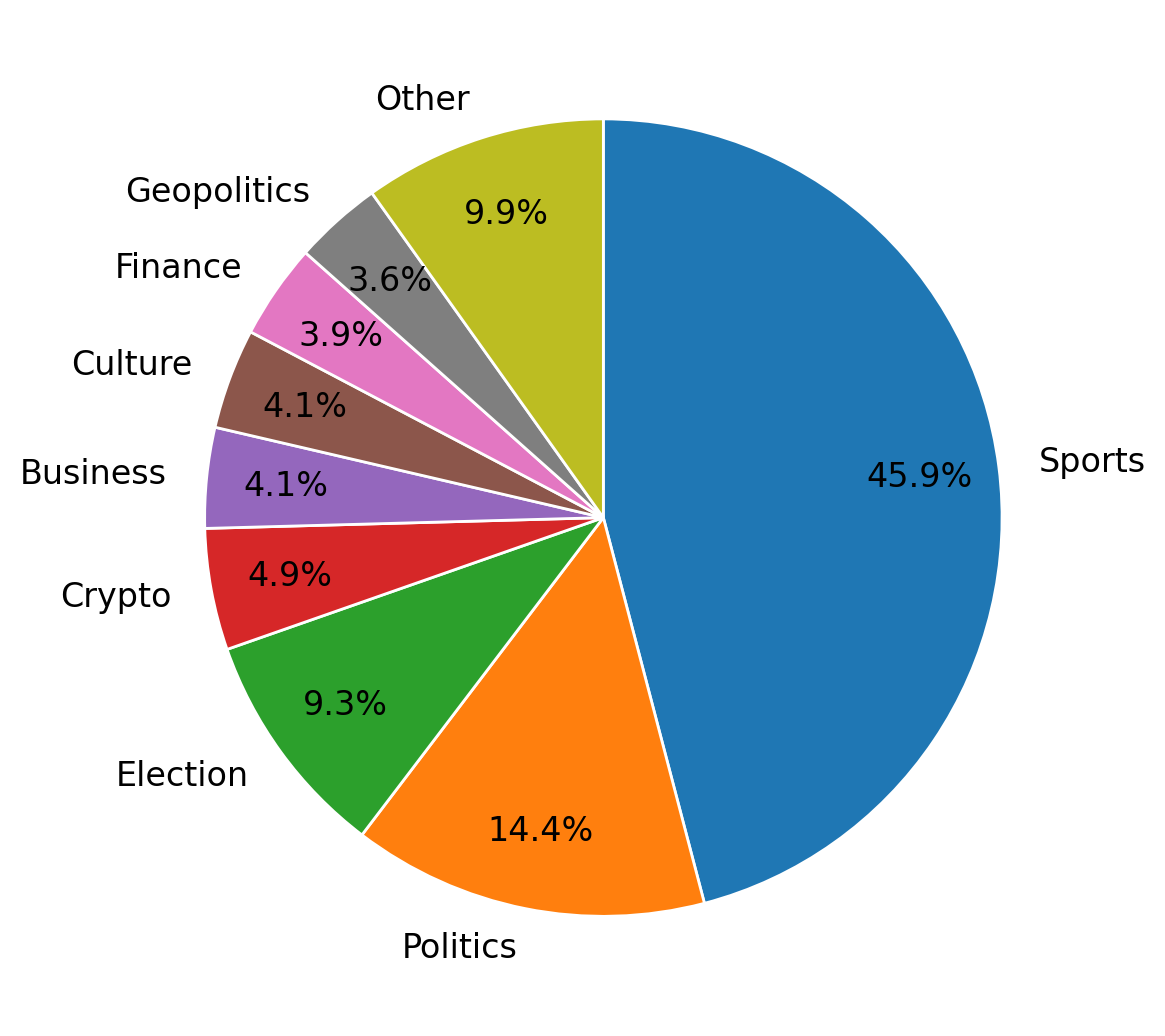

In [185]:
counts = df_exploded["category"].value_counts()

if len(counts) > 13:
    other = counts.tail(13).sum()
    counts = counts.head(len(counts) - 13)
    counts['Other'] = other  # ‘Other’ appended ⇒ plotted last

# plotting
fig, ax = plt.subplots(figsize=(6, 6))
counts.plot.pie(
    labels=counts.index,
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    pctdistance=0.8,
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
)
ax.set_ylabel('')
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

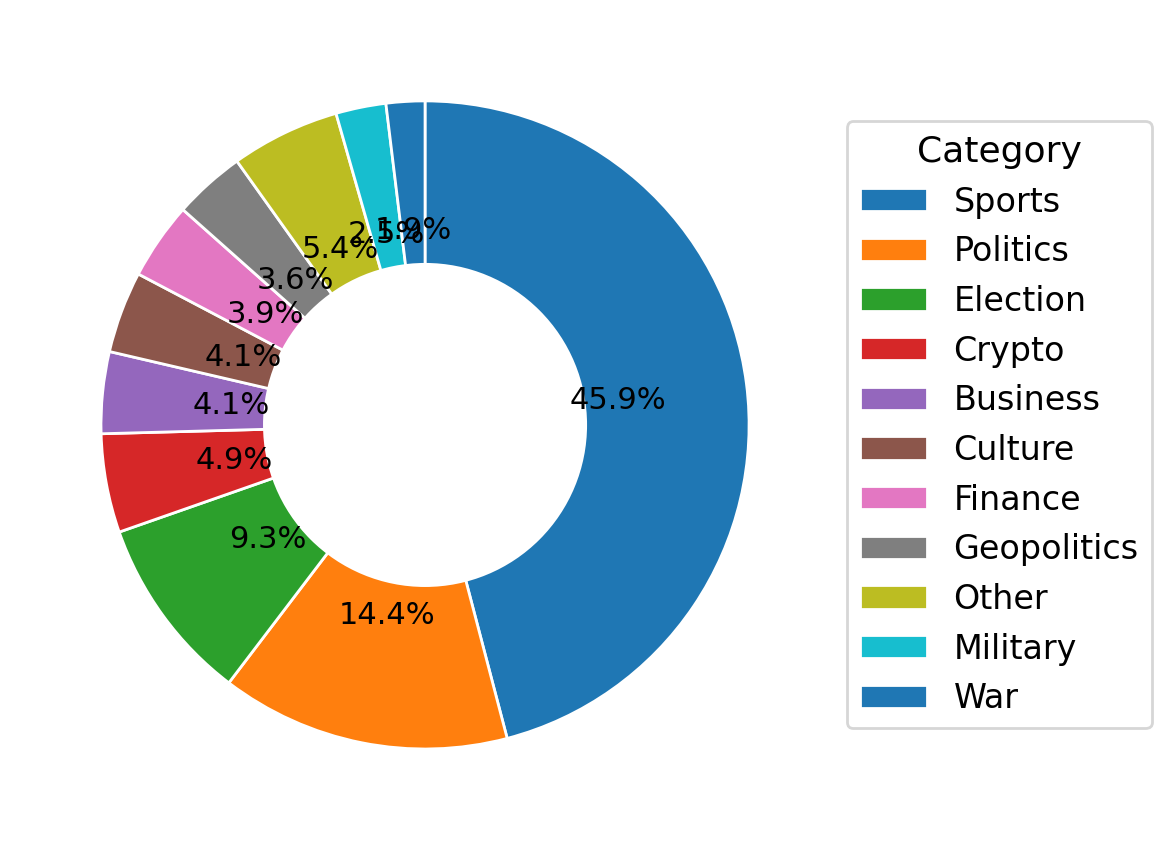

In [ ]:
# агрегация с Other последним
counts = df_exploded["category"].value_counts()
if len(counts) > 12:
    other = counts.tail(len(counts) - 11).sum()
    counts = counts.head(11)
    counts['Other'] =  other

# donut-диаграмма
fig, ax = plt.subplots(figsize=(6, 6))
wedges, _, autotexts = ax.pie(
    counts,
    labels=None,
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    pctdistance=0.6,
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
    textprops={'fontsize': 11}
)
# центральное отверстие
ax.add_artist(plt.Circle((0, 0), 0.50, fc='white'))

# легенда справа
ax.legend(
    wedges,
    counts.index,
    title='Category',
    loc='center left',
    bbox_to_anchor=(1, 0, 0.5, 1),
    fontsize=12,
    title_fontsize=13
)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()


In [150]:
pivot_table.T

setup        deepseek_r1 | basic_prompt | 10 articles | 3  \
category                                                    
Biology                                          0.022500   
Business                                         0.090439   
Crypto                                           0.120072   
Culture                                          0.092544   
Economics                                        0.198542   
Education                                        0.016250   
Election                                         0.123907   
Environment                                      0.360000   
Finance                                          0.129491   
Geopolitics                                      0.152400   
Healthcare                                       0.040833   
Law                                              0.041667   
Mentions                                         0.028333   
Military                                         0.130143   
Music                                            0.022500   
Other                                            0.102917   
Politics                                         0.124061   
Research                                         0.289000   
Science                                          0.128056   
Sports                                           0.218960   
Technology                                       0.158981   
War                                              0.167407   

setup        deepseek_r1 | two_stages | 10 articles | 3  \
category                                                  
Biology                                        0.000000   
Business                                       0.093254   
Crypto                                         0.138955   
Culture                                        0.116189   
Economics                                      0.135208   
Education                                      0.025000   
Election                                       0.132527   
Environment                                    0.202500   
Finance                                        0.132963   
Geopolitics                                    0.136230   
Healthcare                                     0.190833   
Law                                            0.135000   
Mentions                                       0.052933   
Military                                       0.105614   
Music                                          0.640000   
Other                                          0.126183   
Politics                                       0.133767   
Research                                       0.137000   
Science                                        0.119444   
Sports                                         0.240870   
Technology                                     0.144911   
War                                            0.146167   

setup        deepseek_v3 | champs_know | 15 articles | 3  \
category                                                   
Biology                                         0.040000   
Business                                        0.107807   
Crypto                                          0.123317   
Culture                                         0.120879   
Economics                                       0.120000   
Education                                       0.012500   
Election                                        0.119297   
Environment                                     0.490000   
Finance                                         0.134028   
Geopolitics                                     0.119900   
Healthcare                                      0.082500   
Law                                             0.082500   
Mentions                                        0.062500   
Military                                        0.120857   
Music                                           0.562500   
Other                                           0.089653   
Politics                              

In [173]:
pivot_table.T.to_csv("brier_scores_by_setup_and_category.csv")

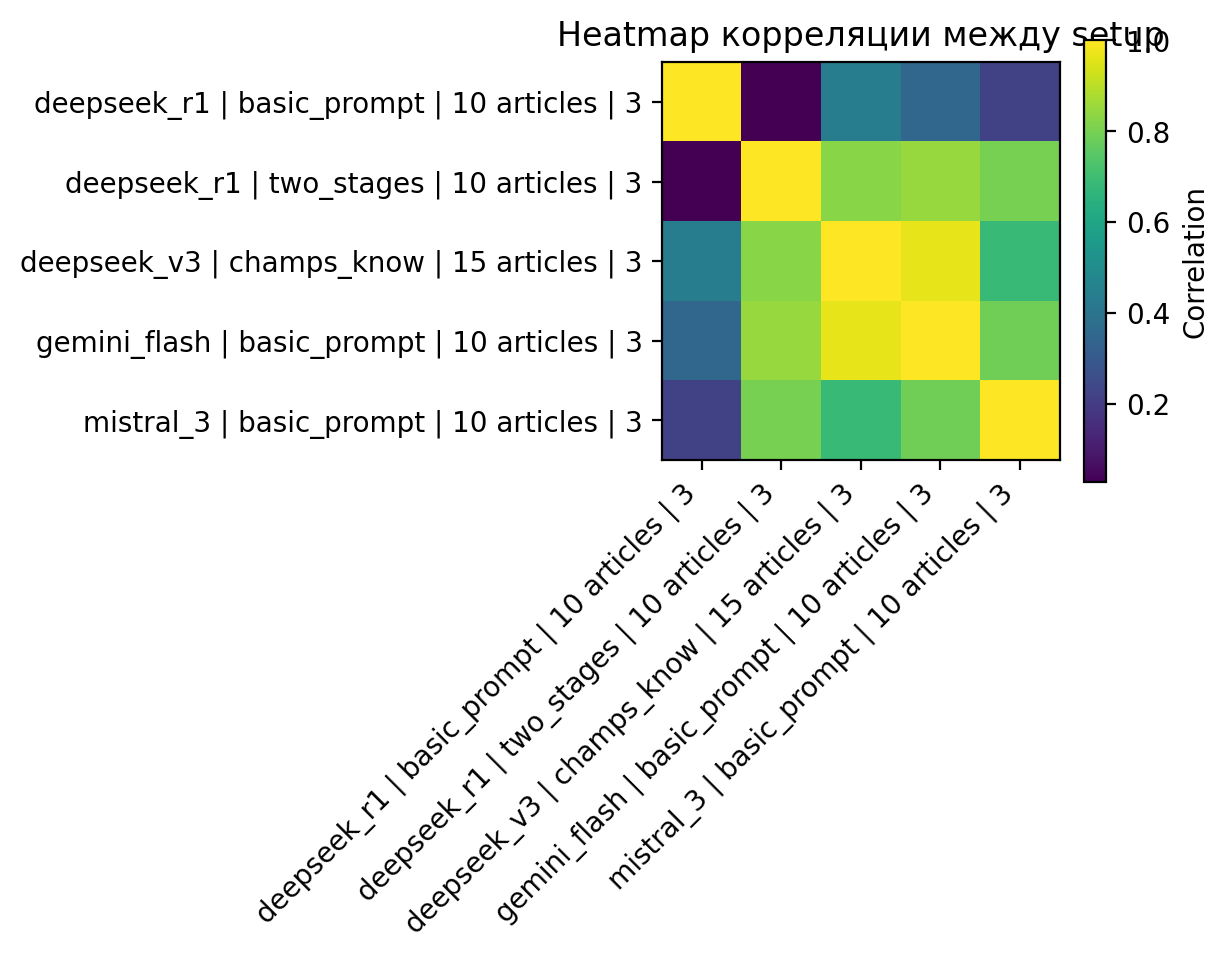

In [80]:
corr_matrix = pivot_table.T.corr()

# heatmap
fig, ax = plt.subplots(figsize=(6, 5))
cax = ax.imshow(corr_matrix, aspect='equal')
ax.set_xticks(range(len(corr_matrix.columns)))
ax.set_yticks(range(len(corr_matrix.index)))
ax.set_xticklabels(corr_matrix.columns, rotation=45, ha='right')
ax.set_yticklabels(corr_matrix.index)
fig.colorbar(cax, ax=ax, label='Correlation')
plt.title('Heatmap корреляции между setup')
plt.tight_layout()
plt.show()

Статистики по длительности (дни):
count    998.000000
mean      17.051731
std       36.818044
min        0.431319
25%        2.910992
50%        6.702616
75%       10.626505
max      364.859363
Name: duration_days, dtype: float64


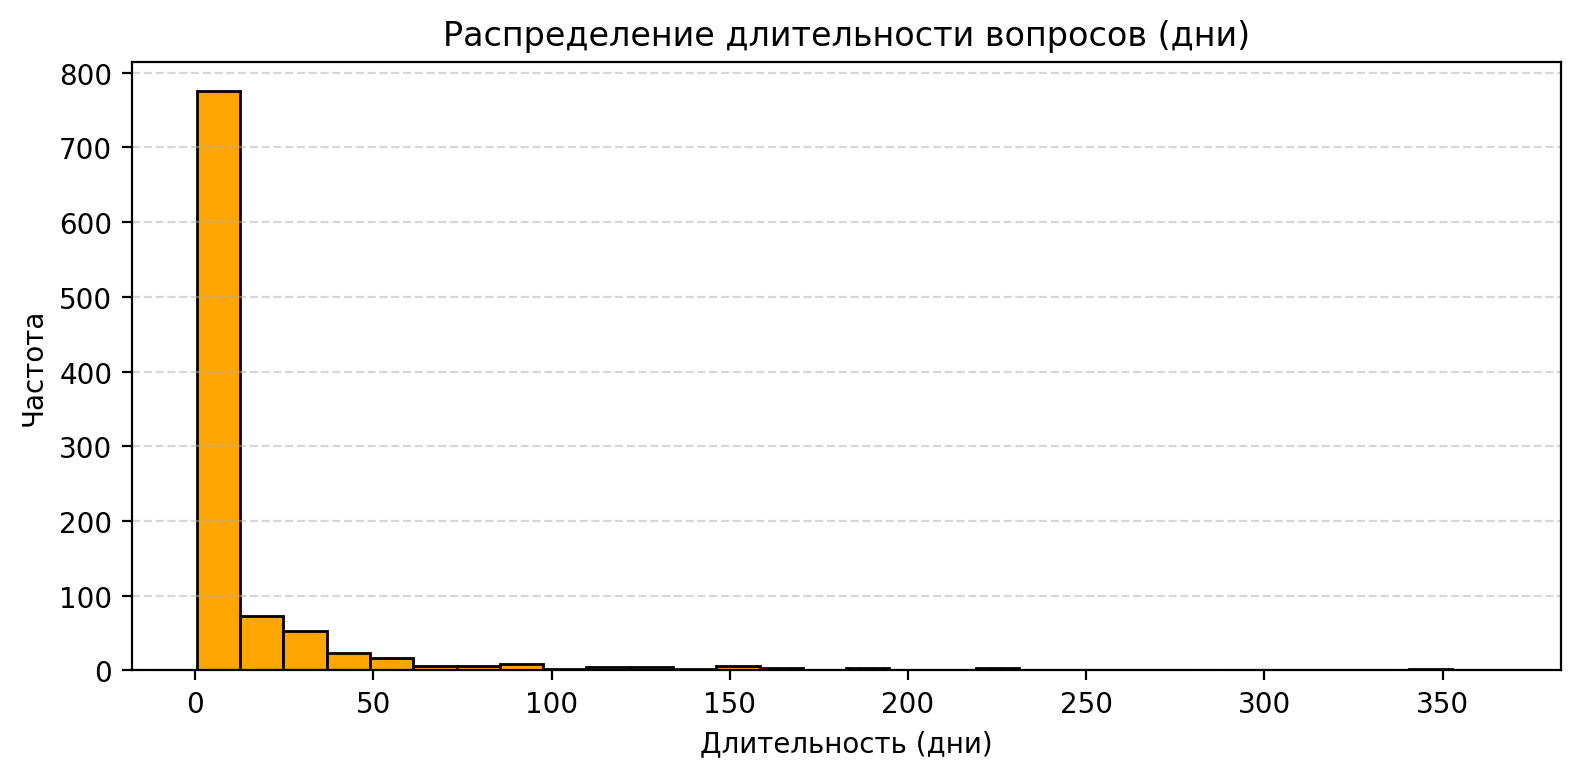


Средние дни до разрешения для точек t_k:
   avg_days_before  avg_days_before_alt
k                                      
1        15.299499            15.299502
2        10.199666            10.199672
3         5.099833             5.099842
4         0.000000             0.000012


In [107]:
data = df[df["setup"] == "deepseek_r1 | basic_prompt | 10 articles | 4"].copy()

data['start_datetime'] = pd.to_datetime(data['start_date'], format='%Y%m%d%H%M%S')
data['end_datetime'] = pd.to_datetime(data['end_date'], format='%Y%m%d%H%M%S')
data['pred_datetime'] = pd.to_datetime(data['pred_date'], format='%Y%m%d%H%M%S')

# Вычисление длительности в днях
data['duration_days'] = (data['pred_datetime'] - data['start_datetime']).dt.total_seconds() / 86400

# Статистики по длительности
stats = data['duration_days'].describe()
print("Статистики по длительности (дни):")
print(stats)

# Гистограмма распределения длительностей
plt.figure(figsize=(8, 4))
plt.hist(data['duration_days'], bins=30, edgecolor='black', color='orange')
plt.title('Распределение длительности вопросов (дни)')
plt.xlabel('Длительность (дни)')
plt.ylabel('Частота')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Вычисление точек t_k и t_k_alt и средних дней до разрешения
results = []
for k in range(1, 5):
    t_col = f"t{k}"
    t_alt_col = f"t{k}_alt"
    days_before_col = f"days_before_{k}"
    days_before_alt_col = f"days_before_{k}_alt"

    data[t_col] = data['start_datetime'] + (data['end_datetime'] - data['start_datetime']) * (k / 4)
    data[t_alt_col] = data['start_datetime'] + ((data['end_datetime'] - data['start_datetime']) - pd.Timedelta(seconds=1)) * (k / 4)

    data[days_before_col] = (data['end_datetime'] - data[t_col]).dt.total_seconds() / 86400
    data[days_before_alt_col] = (data['end_datetime'] - data[t_alt_col]).dt.total_seconds() / 86400

    avg_normal = data[days_before_col].mean()
    avg_alt = data[days_before_alt_col].mean()
    results.append({
        'k': k,
        'avg_days_before': avg_normal,
        'avg_days_before_alt': avg_alt
    })

results_df = pd.DataFrame(results).set_index('k')
print("\nСредние дни до разрешения для точек t_k:")
print(results_df)

Geo map for questions

In [118]:
with open("data/llm_data/geo_and_categories.json", "r") as f:
    events_data = json.load(f)

events_df = pd.DataFrame(events_data)
events_df = events_df[["title", "categories", "locations"]]
events_df = events_df.drop_duplicates(subset='title')

In [ ]:
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import geopandas as gpd
import matplotlib.pyplot as plt

In [119]:
# df — ваш датафрейм с колонкой "locations" (списки строк)
# Преобразуем все вложенные списки в единый список для подсчёта
all_locs = pd.Series([loc for lst in events_df['locations'] for loc in lst])
unique_locs = all_locs.unique()

In [ ]:
# Геокодирование через Nominatim
geolocator = Nominatim(user_agent="geo")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
geo_data = []
for loc in tqdm(unique_locs):
    try:
        r = geocode(loc)
        if r:
            geo_data.append({
                'location': loc,
                'latitude': r.latitude,
                'longitude': r.longitude
            })
    except Exception as e:
        print(f"Error geocoding {loc}: {e}")

geo_df = pd.DataFrame(geo_data)

 29%|██▉       | 180/620 [03:44<13:59,  1.91s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('Arizona State',), **{}).
Traceback (most recent call last):
  File "/Users/andreypetukhov/Documents/Thesis/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py", line 536, in _make_request
    response = conn.getresponse()
               ^^^^^^^^^^^^^^^^^^
  File "/Users/andreypetukhov/Documents/Thesis/.venv/lib/python3.11/site-packages/urllib3/connection.py", line 507, in getresponse
    httplib_response = super().getresponse()
                       ^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/http/client.py", line 1374, in getresponse
    response.begin()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/http/client.py", line 318, in begin
    version, status, reason = self._read_status()
                              ^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versi

In [129]:
geo_df.to_csv("data/llm_data/geo_data.csv", index=False)

In [135]:
geo_df.columns

Index(['location', 'latitude', 'longitude'], dtype='object')

In [143]:
import geopandas
def plot_map_from_local_shapefile(geo_df, shapefile_path):
    """
    Рисует карту мира с локациями из geo_df, используя локальный шейп-файл.
    (Plots a world map with locations from geo_df, using a local shapefile.)
    """
    if not isinstance(geo_df, pd.DataFrame) or geo_df.empty:
        print("Ошибка: geo_df не является DataFrame или пуст.")
        print("(Error: geo_df is not a DataFrame or is empty.)")
        return
    if not ('latitude' in geo_df.columns and 'longitude' in geo_df.columns):
        print("Ошибка: в geo_df отсутствуют колонки 'latitude' и/или 'longitude'.")
        print("(Error: geo_df is missing 'latitude' and/or 'longitude' columns.)")
        return

    location_counts_df = geo_df.groupby(['latitude', 'longitude'], as_index=False).size()
    location_counts_df.rename(columns={'size': 'mention_counts'}, inplace=True)

    if location_counts_df.empty:
        print("Нет данных для отображения после агрегации.")
        print("(No data to display after aggregation.)")
        return

    try:
        world = geopandas.read_file(shapefile_path)
    except Exception as e:
        print(f"Ошибка при загрузке шейп-файла '{shapefile_path}': {e}")
        print(f"(Error loading shapefile '{shapefile_path}': {e})")
        print("Убедитесь, что путь указан верно и все необходимые файлы (.shp, .shx, .dbf и др.) находятся в той же директории.")
        print("(Ensure the path is correct and all necessary files (.shp, .shx, .dbf, etc.) are in the same directory.)")
        return

    fig, ax = plt.subplots(1, 1, figsize=(18, 9))
    world.plot(ax=ax, color='lightgray', edgecolor='darkgray', zorder=1)

    # --- ADJUSTED DOT SIZES ---
    min_marker_size = 50  # Increased from 20
    size_scale_factor = 30 # Adjusted from 25 (tweak as needed)
    sizes = min_marker_size + (location_counts_df['mention_counts'] * size_scale_factor)

    scatter = ax.scatter(
        location_counts_df['longitude'],
        location_counts_df['latitude'],
        s=sizes,
        c=location_counts_df['mention_counts'],
        cmap='viridis',  # --- CHANGED COLORMAP --- (was 'summer')
        alpha=0.7,       # Slightly increased alpha for better visibility if dots overlap
        edgecolors='black', # Changed edge color for better contrast with viridis
        linewidths=0.5,
        zorder=2
    )

    cbar = fig.colorbar(scatter, ax=ax, fraction=0.03, pad=0.02)
    cbar.set_label('Mention Counts', fontsize=14)
    cbar.ax.tick_params(labelsize=12)

    ax.set_xlabel("Longitude", fontsize=14)
    ax.set_ylabel("Latitude", fontsize=14)
    ax.set_title("Locations Mentioned", fontsize=18, pad=20)
    ax.tick_params(labelsize=12)

    ax.set_xlim([-180, 180])
    ax.set_ylim([-60, 90]) # --- ADJUSTED Y-LIMIT LOWER BOUND ---

    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    plt.tight_layout(pad=1.0)
    plt.show()

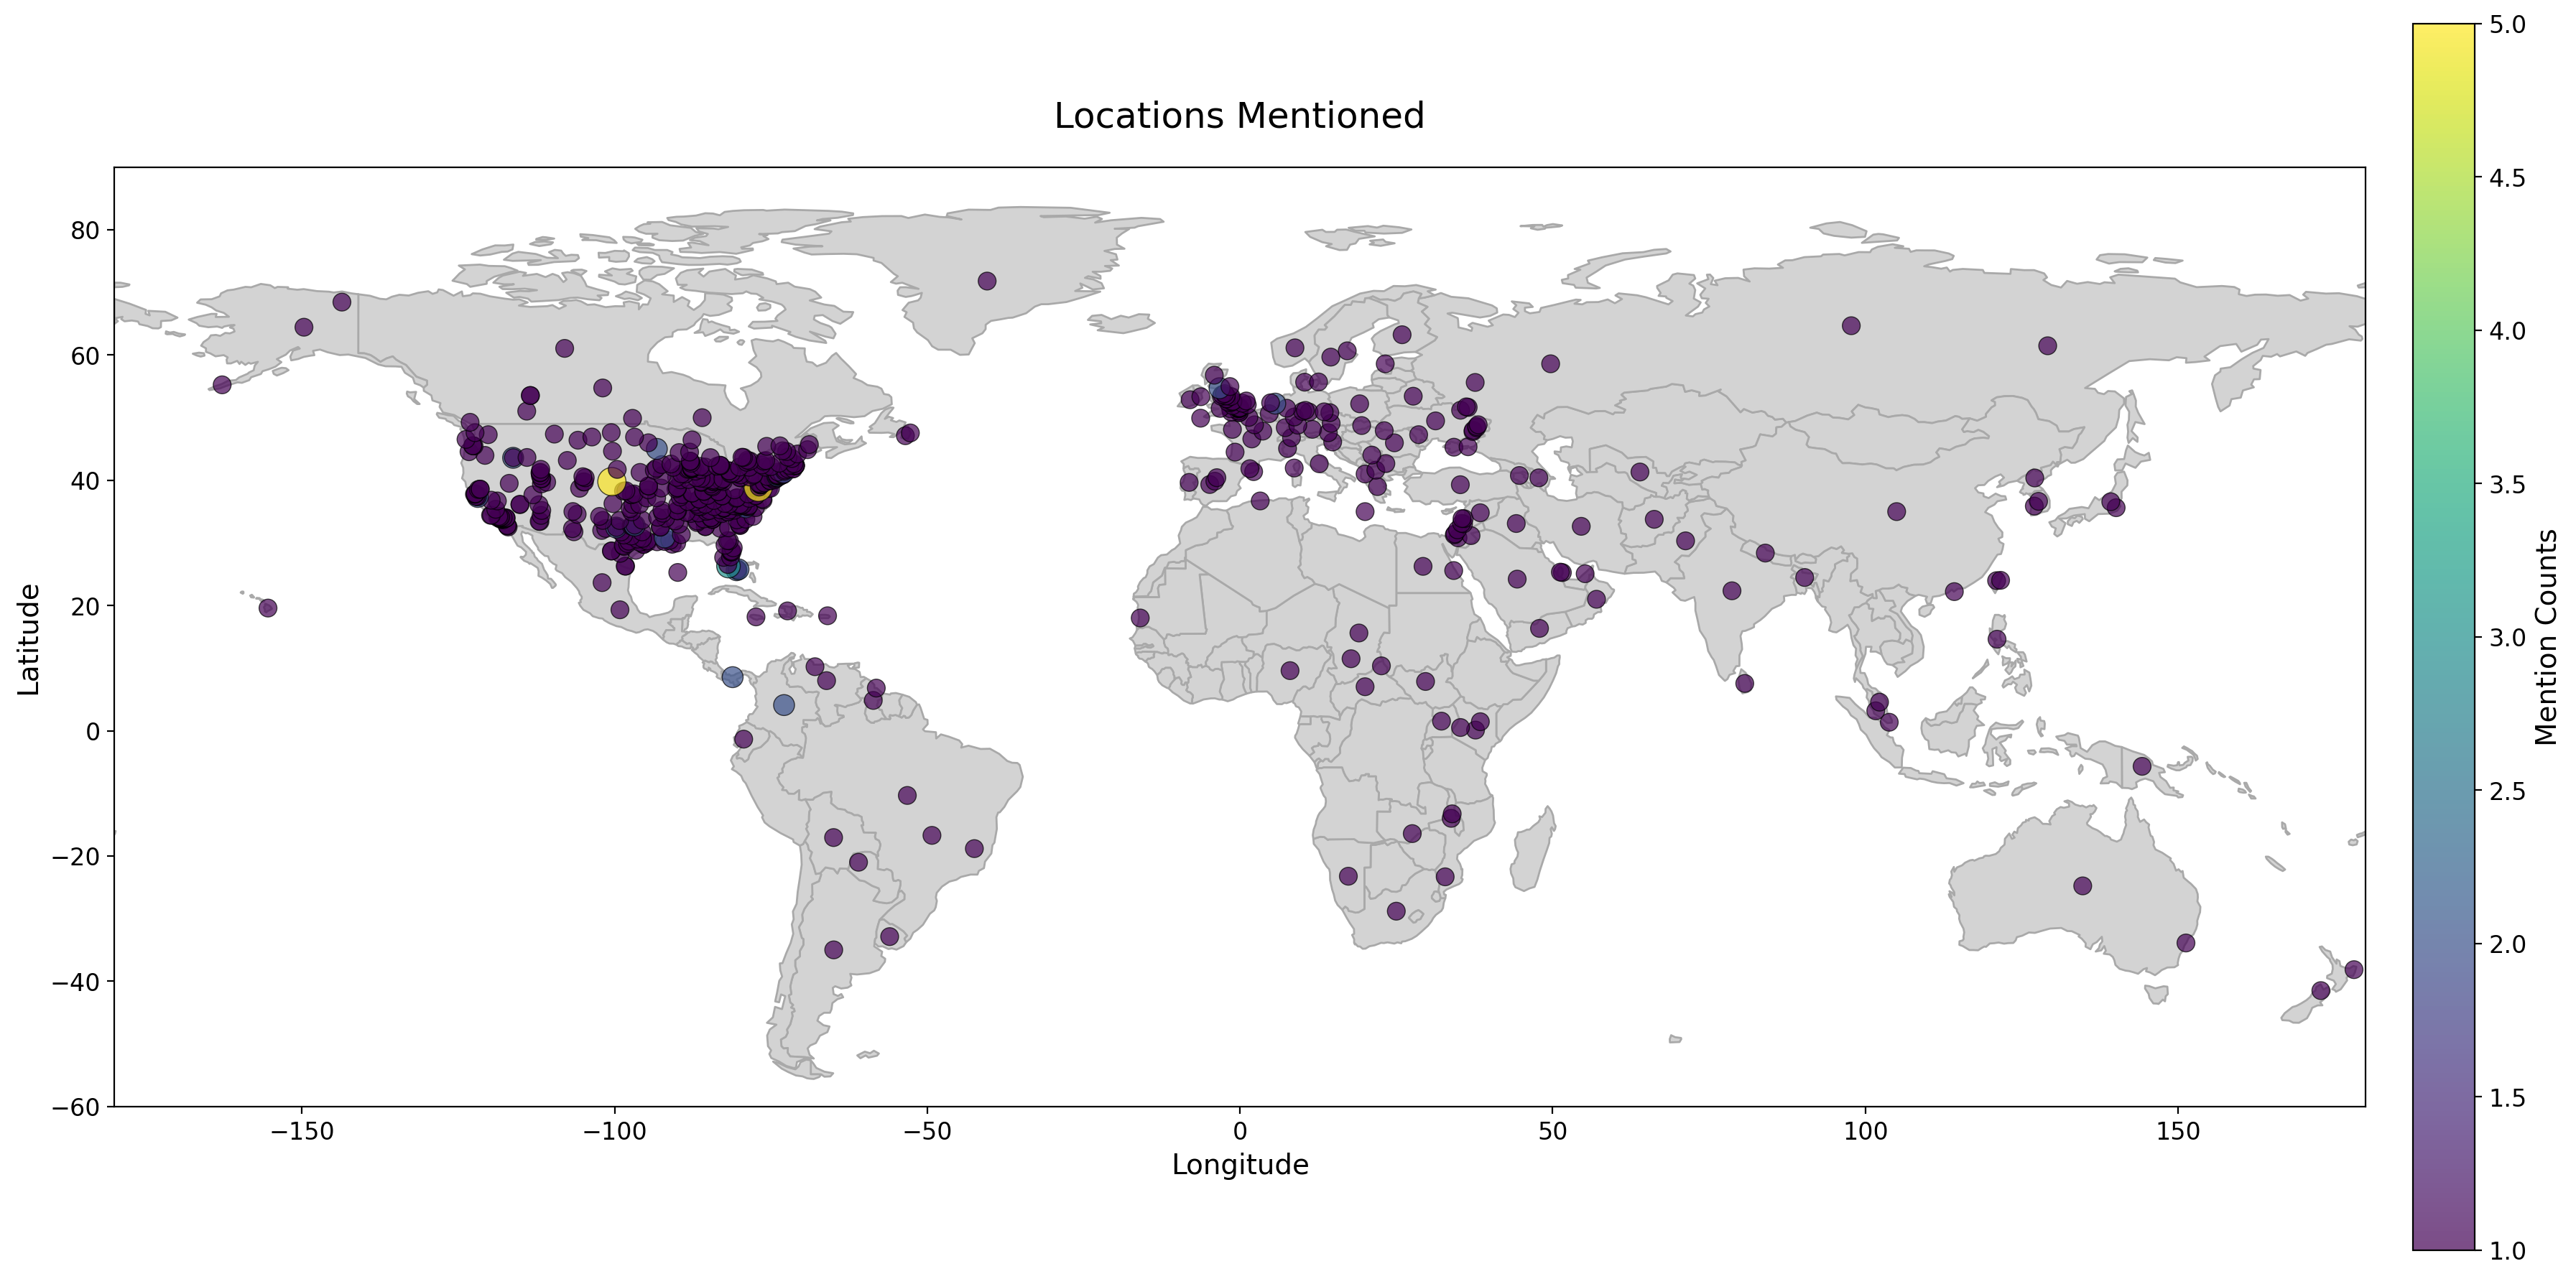

In [144]:
plot_map_from_local_shapefile(geo_df, "data/110m_cultural/ne_110m_admin_0_countries.shp")

In [132]:
import statsmodels.api as sm

# исходные данные
n1, p1 = 1000, 0.425
n2, p2 = 4736, 0.4232
k1 = int(round(n1 * p1))
k2 = int(round(n2 * p2))

# двухсторонний Z-тест для проверки равенства долей
stat, pval = sm.stats.proportions_ztest([k1, k2], [n1, n2])

In [133]:
stat, pval

(0.10805641175516646, 0.9139509440131681)

LOGISTIC AGGREGATION

In [145]:
import pandas as pd
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss, accuracy_score, roc_auc_score

# --- 1. Улучшенный энкодер категорий ---
class CategoryEncoder(BaseEstimator, TransformerMixin):
    """
    Выполняет One-Hot Encoding для колонки, содержащей списки в виде строк.
    Например, '["politics", "economics"]' -> [0, 1, 0, 1, ...]

    Args:
        column_name (str): Имя колонки для кодирования.
    """
    def __init__(self, column_name='categories'):
        self.column_name = column_name
        self.mlb = MultiLabelBinarizer()

    def _parse_lists(self, series):
        """Безопасно преобразует строки в списки."""
        return series.apply(lambda s: ast.literal_eval(s) if isinstance(s, str) else (s if isinstance(s, list) else []))

    def fit(self, X, y=None):
        # Обучаем на уникальных значениях категорий
        parsed_lists = self._parse_lists(X[self.column_name])
        self.mlb.fit(parsed_lists)
        return self

    def transform(self, X):
        # Трансформируем данные
        parsed_lists = self._parse_lists(X[self.column_name])
        encoded_array = self.mlb.transform(parsed_lists)
        return pd.DataFrame(encoded_array, columns=self.mlb.classes_, index=X.index)


# --- 2. Основная функция для обучения и оценки ---
def _train_aggregator(X, y, test_size=0.2, random_state=42, C=0.1, max_iter=1000):
    """
    Внутренняя функция для обучения и оценки модели-агрегатора.
    Принимает на вход готовую матрицу признаков и таргет.
    """
    # Разделение выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Определение численных и категориальных колонок (категории уже закодированы)
    # Численные признаки обычно требуют масштабирования, а OHE - нет.
    numeric_features = [c for c in X.columns if 'pred_k' in c or 'rate' in c or 'num_articles' in c]
    categorical_features = [c for c in X.columns if c not in numeric_features]

    # Создание пайплайна для предобработки
    numeric_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # ColumnTransformer применяет разные пайплайны к разным колонкам
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_pipeline, numeric_features)
        ],
        remainder='passthrough'  # Категориальные OHE-признаки оставляем как есть
    )

    # Финальный пайплайн: предобработка + модель
    model_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(C=C, max_iter=max_iter, random_state=random_state))
    ])

    # Обучение модели
    model_pipeline.fit(X_train, y_train)

    # Получение предсказаний
    y_prob = model_pipeline.predict_proba(X_test)[:, 1]
    y_pred = model_pipeline.predict(X_test)

    # Расчет метрик
    metrics = {
        'brier': brier_score_loss(y_test, y_prob),
        'accuracy': accuracy_score(y_test, y_pred),
        'auc': roc_auc_score(y_test, y_prob)
    }

    # Формирование DataFrame с результатами
    predictions_df = pd.DataFrame({
        'event_id': X_test.index,
        'y_true': y_test,
        'y_pred_prob': y_prob,
        'y_pred': y_pred
    }).reset_index(drop=True)

    return predictions_df, metrics, model_pipeline


# --- 3. Публичные функции-обертки ---
def train_single_model_aggregator(df, model_name, prompt_type=None, use_categories=True, test_size=0.2, random_state=42):
    """
    Готовит данные для одной модели и обучает на них агрегатор.
    """
    # Фильтрация данных по указанной модели
    mask = df['model'] == model_name
    if prompt_type is not None:
        mask &= df['prompt_type'] == prompt_type
    df_model = df[mask].copy() # .copy() для избежания SettingWithCopyWarning

    # Получаем уникальные события, чтобы взять из них мета-данные
    df_unique_events = df_model.drop_duplicates('event_id').set_index('event_id')

    # Преобразуем данные из длинного формата в широкий
    # Каждая колонка - это вероятность для определенного 'k'
    pivot_table = df_model.pivot(index='event_id', columns='k', values='probability_yes')
    pivot_table = pivot_table.rename(columns=lambda c: f"pred_k{c}")

    # Собираем все признаки в одну матрицу X
    X = pivot_table.join(df_unique_events[['num_articles_used']])
    
    # Добавляем OHE-признаки категорий, если требуется
    if use_categories:
        cat_encoder = CategoryEncoder(column_name='categories')
        category_features = cat_encoder.fit_transform(df_unique_events[['categories']])
        X = X.join(category_features)
        
    y = df_unique_events['true_label']
    
    # Удаляем строки с пропусками в y и соответствующие им в X
    valid_indices = y.dropna().index
    X = X.loc[valid_indices]
    y = y.loc[valid_indices]

    # Вызов основной функции для обучения
    return _train_aggregator(X, y, test_size=test_size, random_state=random_state)


def train_multi_model_aggregator(df, model_list, use_categories=True, test_size=0.2, random_state=42):
    """
    Готовит данные для нескольких моделей и обучает на них агрегатор.
    """
    # Уникальные события для мета-данных
    df_unique_events = df.drop_duplicates('event_id').set_index('event_id')

    pivot_frames = []
    for model_name in model_list:
        df_model = df[df['model'] == model_name]
        pivot = df_model.pivot(index='event_id', columns='k', values='probability_yes')
        # Добавляем префикс с названием модели, чтобы избежать конфликта колонок
        pivot = pivot.rename(columns=lambda c: f"{model_name}_pred_k{c}")
        pivot_frames.append(pivot)
        
    # Объединяем предсказания от всех моделей
    X = pd.concat(pivot_frames, axis=1)

    # Добавляем другие признаки, если они есть
    if 'base_rate' in df_unique_events.columns:
        X = X.join(df_unique_events['base_rate'])
    
    if use_categories:
        cat_encoder = CategoryEncoder(column_name='categories')
        category_features = cat_encoder.fit_transform(df_unique_events[['categories']])
        X = X.join(category_features)

    y = df_unique_events['true_label']

    # Удаляем строки с пропусками в y и соответствующие им в X
    valid_indices = y.dropna().index
    X = X.loc[valid_indices]
    y = y.loc[valid_indices]
    
    # Удаляем строки, где все признаки - NaN (могли появиться после join'ов)
    X = X.dropna(how='all')
    y = y.loc[X.index]

    return _train_aggregator(X, y, test_size=test_size, random_state=random_state)

